# Project Title Here

**Names**: Sydney Casey, Jake Hunnius, Ben Leidig, Lily Novosel


## 1. Introduction - Sydney

The drugs dataset contains information about drug use for people in three different age groups across U.S. states. In this analysis we focus on comparing drug use rates vary by state for people aged 18-25. According to a study published in the National Library of Medicine, young adults are more likely to have substance abuse disorders than other age groups, but less likely to receive treatment (Substance Abuse and Mental Health Services Administration, 2025). Therefore, additional analysis is needed to understand what causes this discrepancy and whether patterns exist between particular states. It's important to understand drug use in developing adults to gain insight on which states face similar situations. From there, we can identify which states have the best and worst support programs for young adult drug users. State and federal legislators who are tracking funding for drug abuse programs would benefit from the findings in this cluster analysis. They could identify which groups of states face similar issues and decide whether the funding is being used effectively in the programs those states offer. The next steps would include contacting underperforming states to increase, decrease, or reallocate resources appropriately. If the clustering algorithm doesn't find all the inherent clusters, legislators would miss out on valuable, nuanced information on drug use within states. States with significantly different drug use rates could be grouped together, leading to program implementations or funding that don't properly meet the states' needs. Similarly, if the clustering algorithm erroneously splits an inherent cluster, states that actually face comparable patterns of young adult drug use could be treated differently, leading to inefficient or duplicate resource allocation. These analyses are important in understanding which types of U.S. states face similar drug use patterns, which drugs most strongly distinuish those patterns, or if there exist any states with vastly different drug use rates than the others. With this information, legislators can implement more personalized and effective programs to counter drug use in young adults.

First, we cluster the dataset with fuzzy c-means. Obtaining a fuzzy clustering result is beneficial in identifying clusters even if they are overlapping. We could also use each state's partial cluster membership to flag straddle states. Using this information, legislators could identify states that share drug use characteristics with several clusters and could benefit from a blend of the existing programs. Next we cluster the dataset using hierarchical agglomerative clustering with complete linkage. With this algorithm, we can quantify the nearness of clusters and identify any existing outliers. This will help answer the research question of whether any states exist with vastly different metrics than all other states, and which drugs most strongly distinguish existing patterns. From there, legislators can propose funding and program changes that aim to reduce drug abuse in young adults.

In this report, we discuss the structure of the dataset and how we extract the necessary information to perform a cluster analysis. We then perform basic descriptive analysis and determine whether to scale the data. Next, we use t-SNE to understand the clusterability of the dataset and select which clustering algorithms best identify the inherent clusters. We cluster the dataset using fuzzy c-means and hierarchical agglomerative clustering with complete linkage, analyzing the effectiveness of each algorithm and parameter tuning as necessary. We then compare the best result of each clustering algorithm and analyze which variables characterize each cluster. Finally, we address any shortcomings in the analysis and make a recommendation based on our key findings. 


In [14]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')

from skfuzzy.cluster import cmeans

from scipy.spatial.distance import pdist, squareform

## 2. Dataset Discussion - Lily

Dataset Display
* Read your csv file and display the first 5 rows of your dataframe.
* How many rows are in your dataframe (originally before any data cleaning)?

Dataset Source
* State where YOU got this csv file (dataset) from.
* Provide a link/reference to where it came from.
* State when you downloaded this csv file.

Original Dataset Information In the place where you found this dataset, try to answer the
following questions. If the source does not give the answer to these questions, say so. 4
13
* What do the rows (ie. observations) represent in this dataset?
* How was this dataset collected?
* Is this dataset inclusive of ALL possible types of observations that could have been
considered in this dataset? If not, what types of observations might be left out?

Selected Variables
* Briefly describe the variables you intend to use in your analysis.
* Why do you think the inclusion of these variables are best when it comes to your research motivation?
* Should each of these variable be considered equally important in the analysis?

In [15]:
df = pd.read_csv('drugs.csv')
print(f'Original Dataset:\n{df.shape}')
display(df.head())
states = df['State'].unique().tolist()
df = df\
    .groupby('State').agg('mean')\
    .reset_index()\
    .drop(columns=[col for col in df.columns if (not col.startswith('Rates') or not col.endswith('.18-25')) and col != 'State'])
print(f'----------------\nModified Dataset:\n{df.shape}')
display(df.head())
X = df.select_dtypes([float, int]).to_numpy()

Original Dataset:
(867, 53)


,State,Year,Population.12-17,Population.18-25,Population.26+,Totals.Alcohol.Use Disorder Past Year.12-17,Totals.Alcohol.Use Disorder Past Year.18-25,Totals.Alcohol.Use Disorder Past Year.26+,Rates.Alcohol.Use Disorder Past Year.12-17,Rates.Alcohol.Use Disorder Past Year.18-25,...,Totals.Marijuana.Used Past Year.26+,Rates.Marijuana.Used Past Year.12-17,Rates.Marijuana.Used Past Year.18-25,Rates.Marijuana.Used Past Year.26+,Totals.Tobacco.Use Past Month.12-17,Totals.Tobacco.Use Past Month.18-25,Totals.Tobacco.Use Past Month.26+,Rates.Tobacco.Use Past Month.12-17,Rates.Tobacco.Use Past Month.18-25,Rates.Tobacco.Use Past Month.26+
0,Alabama,2002,380805,499453,2812905,18,68,138,48.336,136.490,...,141,127.535,237.880,50.275,63,226,930,166.578,451.976,330.659
1,Alaska,2002,69400,62791,368460,4,12,27,61.479,187.891,...,46,188.730,389.026,124.566,11,30,112,163.918,484.270,304.220
2,Arizona,2002,485521,602265,3329482,36,117,258,73.819,193.626,...,215,169.646,275.435,64.640,73,240,1032,151.071,397.968,309.969
3,Arkansas,2002,232986,302029,1687337,14,53,101,61.457,175.913,...,104,157.567,288.856,61.510,46,169,660,195.714,558.846,391.210
4,California,2002,3140739,3919577,21392421,173,581,1298,55.109,148.312,...,1670,141.067,282.887,78.068,290,1377,4721,92.235,351.353,220.699


----------------
Modified Dataset:
(51, 9)


,State,Rates.Alcohol.Use Disorder Past Year.18-25,Rates.Alcohol.Use Past Month.18-25,Rates.Tobacco.Cigarette Past Month.18-25,Rates.Illicit Drugs.Cocaine Used Past Year.18-25,Rates.Marijuana.New Users.18-25,Rates.Marijuana.Used Past Month.18-25,Rates.Marijuana.Used Past Year.18-25,Rates.Tobacco.Use Past Month.18-25
0,Alabama,115.566235,514.068706,343.957647,39.954000,57.573647,144.057882,243.660941,423.839765
1,Alaska,148.890824,586.418471,355.791176,61.621882,84.826824,237.804118,372.123529,423.792706
2,Arizona,148.500118,565.915353,302.728706,67.284235,68.157059,171.207471,284.355588,354.066882
3,Arkansas,132.029059,525.740412,372.494765,41.915000,62.762353,154.143059,263.992529,441.088588
4,California,143.550471,569.151118,253.590471,64.952765,75.623824,201.858588,324.389294,293.485471


In the drugs dataset, there are a total of 867 rows before any data cleaning. This csv file was one of the three dataset options provided to us in the project specificiations folder. The full dataset can be found here at https://corgis-edu.github.io/corgis/csv/drugs/ and is provided to us via GitHub. The dataset was downloaded on 11/8/2025.

The rows of this dataset represent a single state observation for a specific year, between 2002 and 2018. The columns of the dataset report the population size , the total amount of people with a drug use disorder, and usage rates per 1000 people for different age groups. This dataset comes from the National Survey on Drug Use and Health (NSDUH) and the data was collected from individual states. Because the NSDUH aggregates the data for each state with limited ages and drug types, the drugs dataset is not fully inclusive of all types of observations. We don't have access to each individual survey response, age groups younger than twelve, or drugs other than alcohol, marijuana, tobacco, and cocaine. We plan to only use the rate-based variables for each drug group, limited to the ages 18-25 while averaging across the years for each indiviudal state. We chose to use rates rather than totals because rates would account for the population size and create more meaningful comparisons across the states. We also decided to focus on the ages 18-25 because not only is it more relevant to us as college students, but it also represents a population that is more vulnerable to developing drug use disorders. Not all drug rates contribute equally and can vary greatly across different states. This is why it's important for us to scale our variables to ensure that certain rates don't dominate our unsupervised learning.

## 3. Dataset Cleaning and Exploration - Jake

Missing Value Detection and Cleaning
* Does your dataset have any missing values?
* If so, clean these missing values.
* Are there any downsides to cleaning the missing values in this particular way?

Outlier Identification - Two Variable Outliers (IF YOUR DATASET IS IMAGES, YOU CAN SKIP)
*For every pair of numerical explanatory variables that you're using, create a scatterplot.
* Are you able to detect any outliers in these plots?

Outlier Identification - 3+ Variable Outliers
*Use either a (KNN distance plot or a single linkage dendrogram) to look for outliers including
those that can only be seen in 3 or more dimensions.
* How many outlier/noise points are being suggested?

Outlier Consideration
*In the context of your research motivation, what do you think should be done with any
identified outliers? Explain.
- Should they be dropped? If so, what are some of the pros and cons of dropping these
outliers?
- Should they be clustered in their own singleton clusters?
- Should they be clustered with larger clusters that may happen to be further away?
* If you identified outliers in your dataset, does this impact the type of clustering algorithms
or clustering evaluation metrics that you might use in your analysis? Explain.

Noise Consideration and Identification
* Use a technique discussed in this class to determine if your dataset has any noise.
*In the context of your research motivation, what do you think should be done with any
identified noise? Explain.
* If you identified noise in your dataset, does this impact the type of clustering algorithms or
clustering evaluation metrics that you might use in your analysis? Explain.

Other Data Cleaning
* Were there any other data cleaning steps that you deemed suitable for this analysis? What
were they? Why did you choose to perform this additional data cleaning?
* If there are, do so here.
* If you dropped rows, how many did you drop?

- No missing values
- Show scatterplots with outliers (not full pairplot)
- Show KNN plot for outliers or single linkage
- Outlier treatment --> definitely don't outliers, will look into further analysis about what to do with outliers
- Explain why outliers impact clustering method choice
- Talk about noise in the dataset
- Grouped by state, taking mean of only the `Rate` columns (so average of each state + DC over all years)

## 4. Basic Descriptive Analytics

* For your numerical attributes, calculate basic summary statistics about each attribute.
* For any categorical attributes (including the pre-assigned class labels, if your dataset has
any) count up the number of observations of each type.
* Determine if there exist are any strong pairwise relationships between the variables in your
dataset.

## 5. Scaling Decisions

From your analyses conducted here, discuss whether you should scale the dataset or not.
Explain why or why not. If you choose to scale, then do so in this section here.

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns[1:])

## 6. Clusterability and Clustering Structure - Ben

t-SNE Plots + Clusterability Check
* Create some appropriate t-SNE plots (6 perplexity values, 2 random states each).
* Select a representative t-SNE plot that displays similar patterns seen across many plots.

Describe the Underlying Clustering Structure of the Dataset
What do your t-SNE plots suggest about the following:
* Is your dataset clusterable? (THE ANSWER TO THIS SHOULD BE YES)
* Approximately how many underlying clusters does the data have?
* What are the shapes of the underlying clusters?
* Are the clusters balanced in size?
* Are there are any clusters that are not well-separated?
* Is there any evidence of nested cluster relationships in this dataset?

Clustering Structure and Attribute Association
* Is there an association between each of the attributes and the clustering structure
suggested by the t-SNE plot? Show the appropriate visualizations to explain. (That is, you
should color-code your t-SNE plot by each of your attributes and talk about the amount of
association between the attribute labels and the t-SNE plot suggested clusters).

Understanding the t-SNE algorithm
* Caution your reader about 4 original dataset properties that your t-SNE plots are not able to reveal or represent.

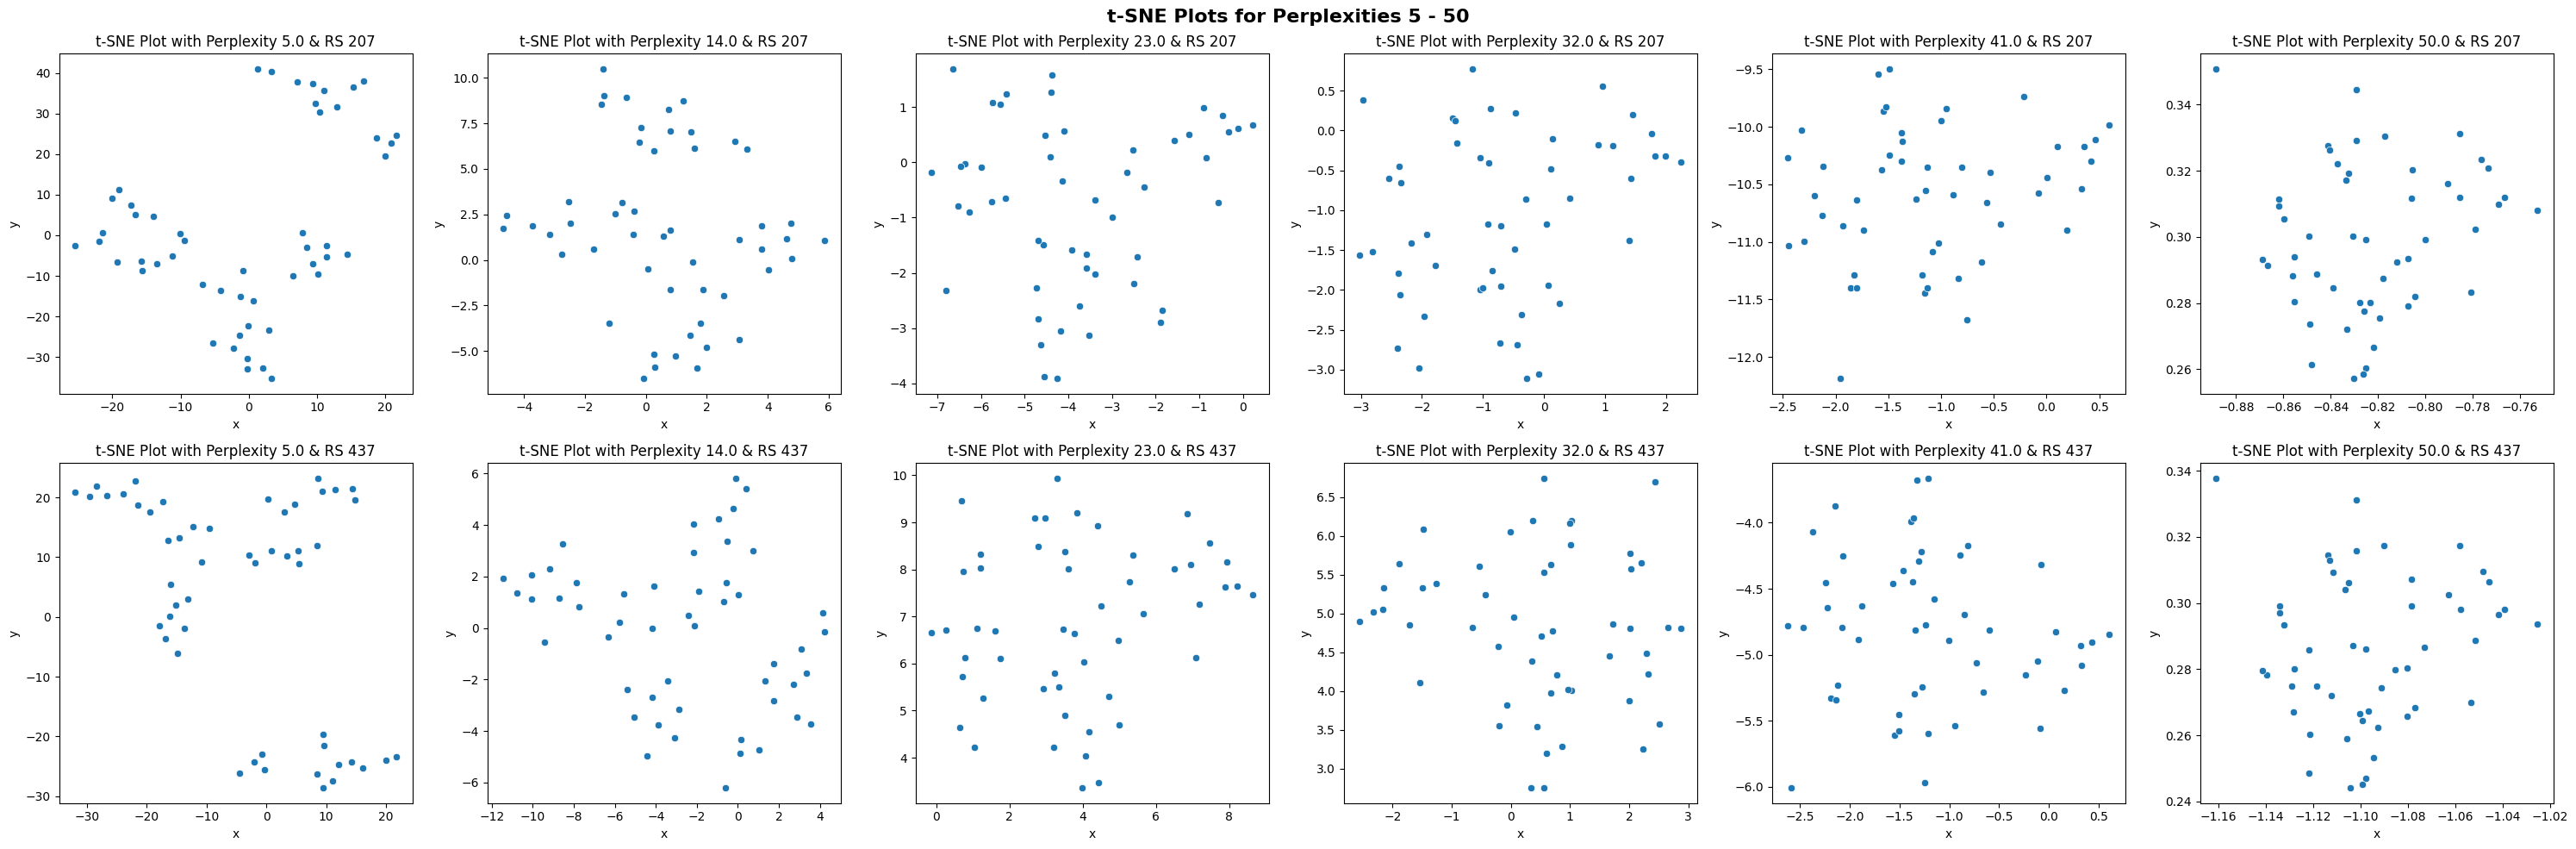

In [17]:
## 5 - 50 PERPLEXITY
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
for col, perp in enumerate(np.linspace(5, 50, 6)):
    for row, rs in enumerate((207, 437)):
        ax = axes[row, col]
        tsne = TSNE(
            n_components=2, init='random',
            perplexity=perp, random_state=rs
        )
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax)
        ax.set_title(f't-SNE Plot with Perplexity {perp} & RS {rs}')
fig.suptitle('t-SNE Plots for Perplexities 5 - 50', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

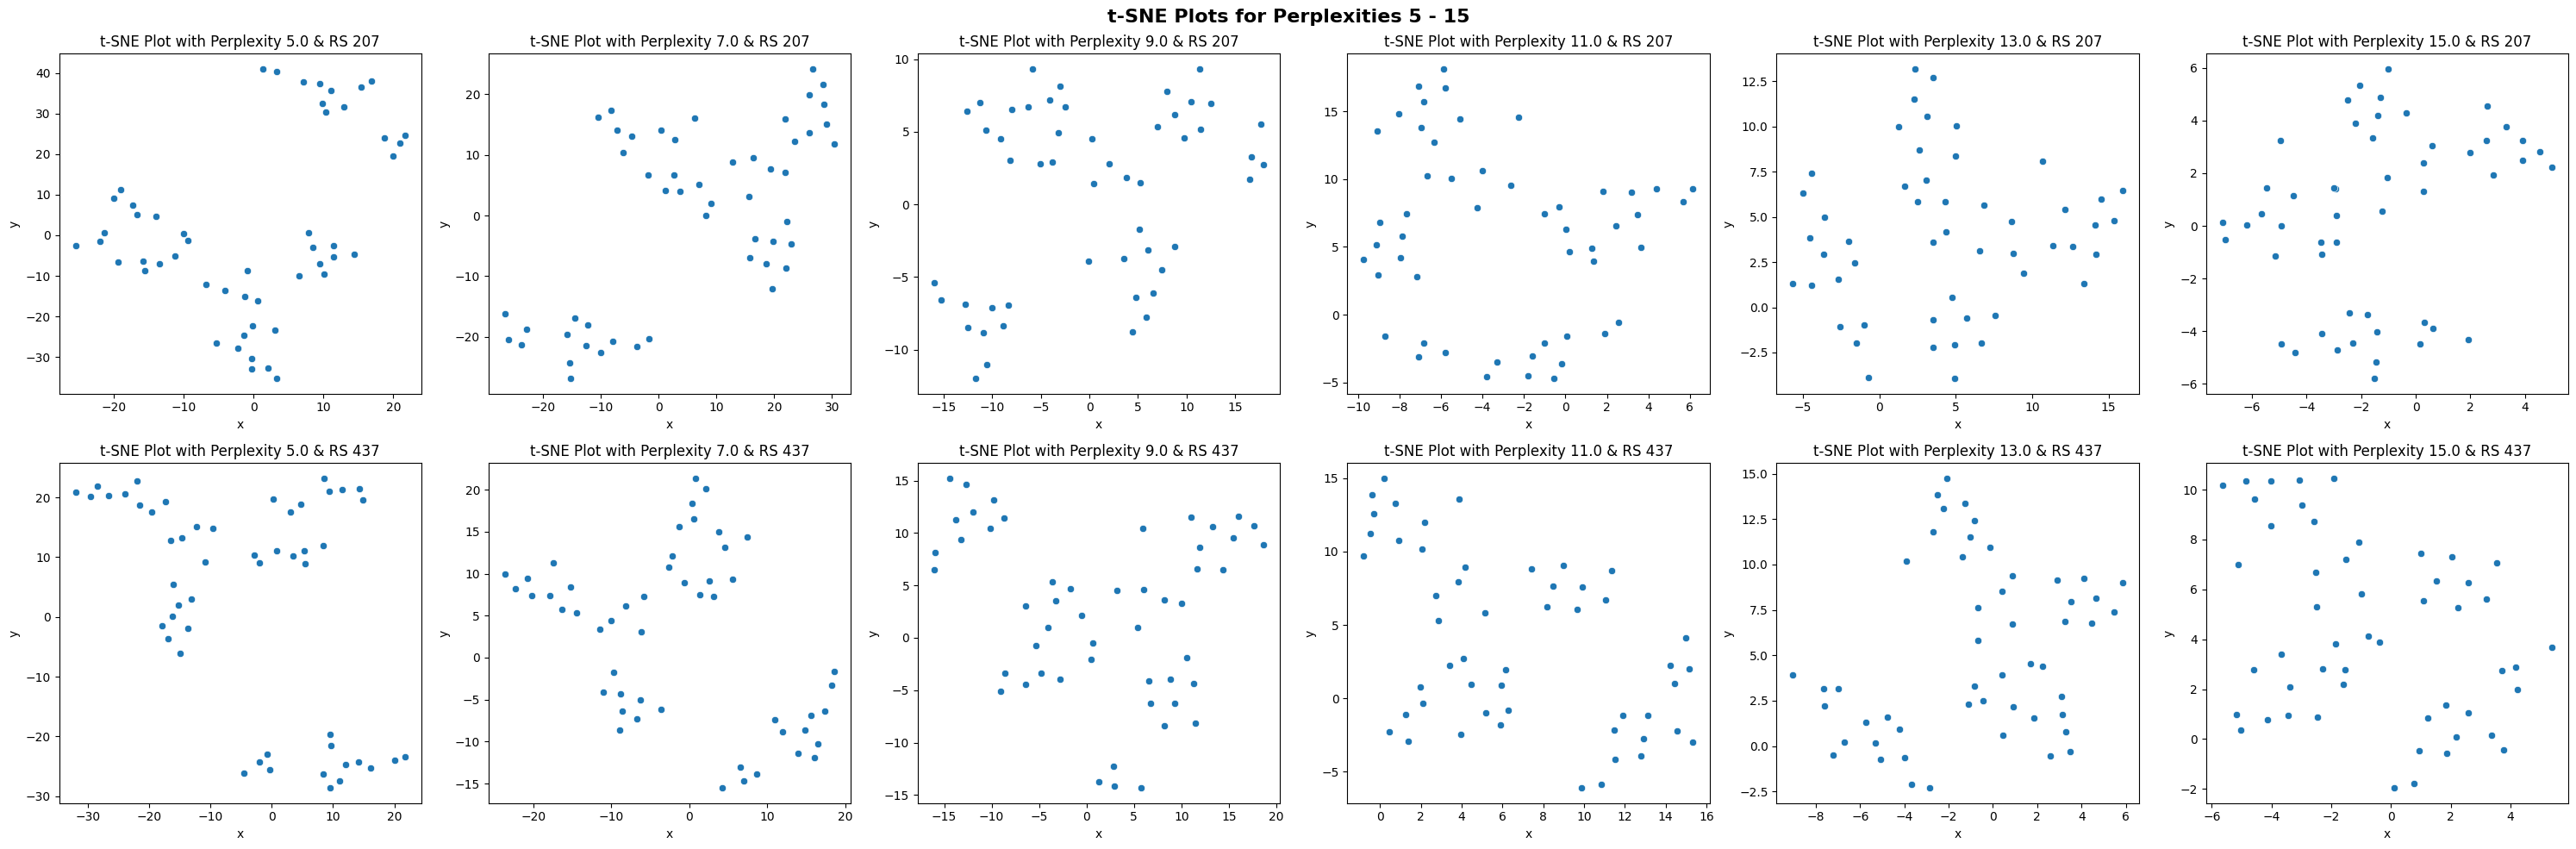

In [18]:
## 5 - 15 PERPLEXITY
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
for col, perp in enumerate(np.linspace(5, 15, 6)):
    for row, rs in enumerate((207, 437)):
        ax = axes[row, col]
        tsne = TSNE(
            n_components=2, init='random',
            perplexity=perp, random_state=rs
        )
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax)
        ax.set_title(f't-SNE Plot with Perplexity {perp} & RS {rs}')
fig.suptitle('t-SNE Plots for Perplexities 5 - 15', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

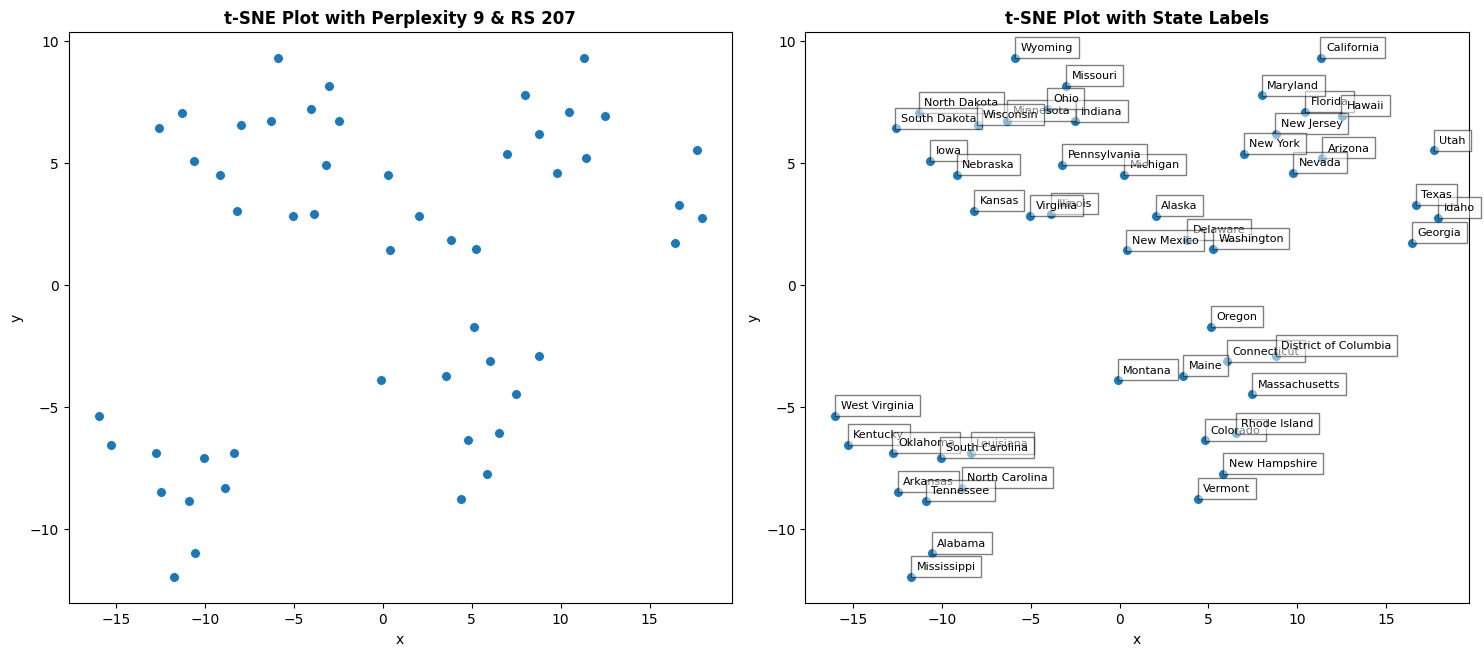

In [19]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10*(2/3)))
tsne = TSNE(
    n_components=2, init='random',
    perplexity=9, random_state=207
)
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])

sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax0, s=50)
ax0.set_title('t-SNE Plot with Perplexity 9 & RS 207', fontweight='bold')

sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax1, s=50)
ax1.set_title('t-SNE Plot with State Labels', fontweight='bold')
for i in range(df_tsne.shape[0]):
    ax1.text(
        x=df_tsne.loc[i, 'x']+0.3, y=df_tsne.loc[i, 'y']+0.3,
        s=states[i],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )

plt.tight_layout()
plt.show()

First, twelve different t-SNE plots were made, each with a different perplexity value or random state value, between perplexities five through fifty. However, since there are only fifty-one observations in the dataset (the fifty United States plus the District of Columbia), high perplexity values (i.e., near fifty) approach $n$, the number of observations in the dataset. Accordingly, these t-SNE plots show little clustering structure. So, twelce new t-SNE plots were again made, but this time with perplexities spanning from five to fifteen, only. These plots demonstrate a clear clustering structure. The representative t-SNE plot, with a perplexity of 9 (and random state of 207), shows roughly four clusters. These "main" clusters are approximately spherical or elongated ovoidal. Each cluster is also approximately balanced in the number of observations. There also appear to be at least two clusters that are not well-separated. Within two of the main clusters, there seem to be at least two "subclusters" in both. 

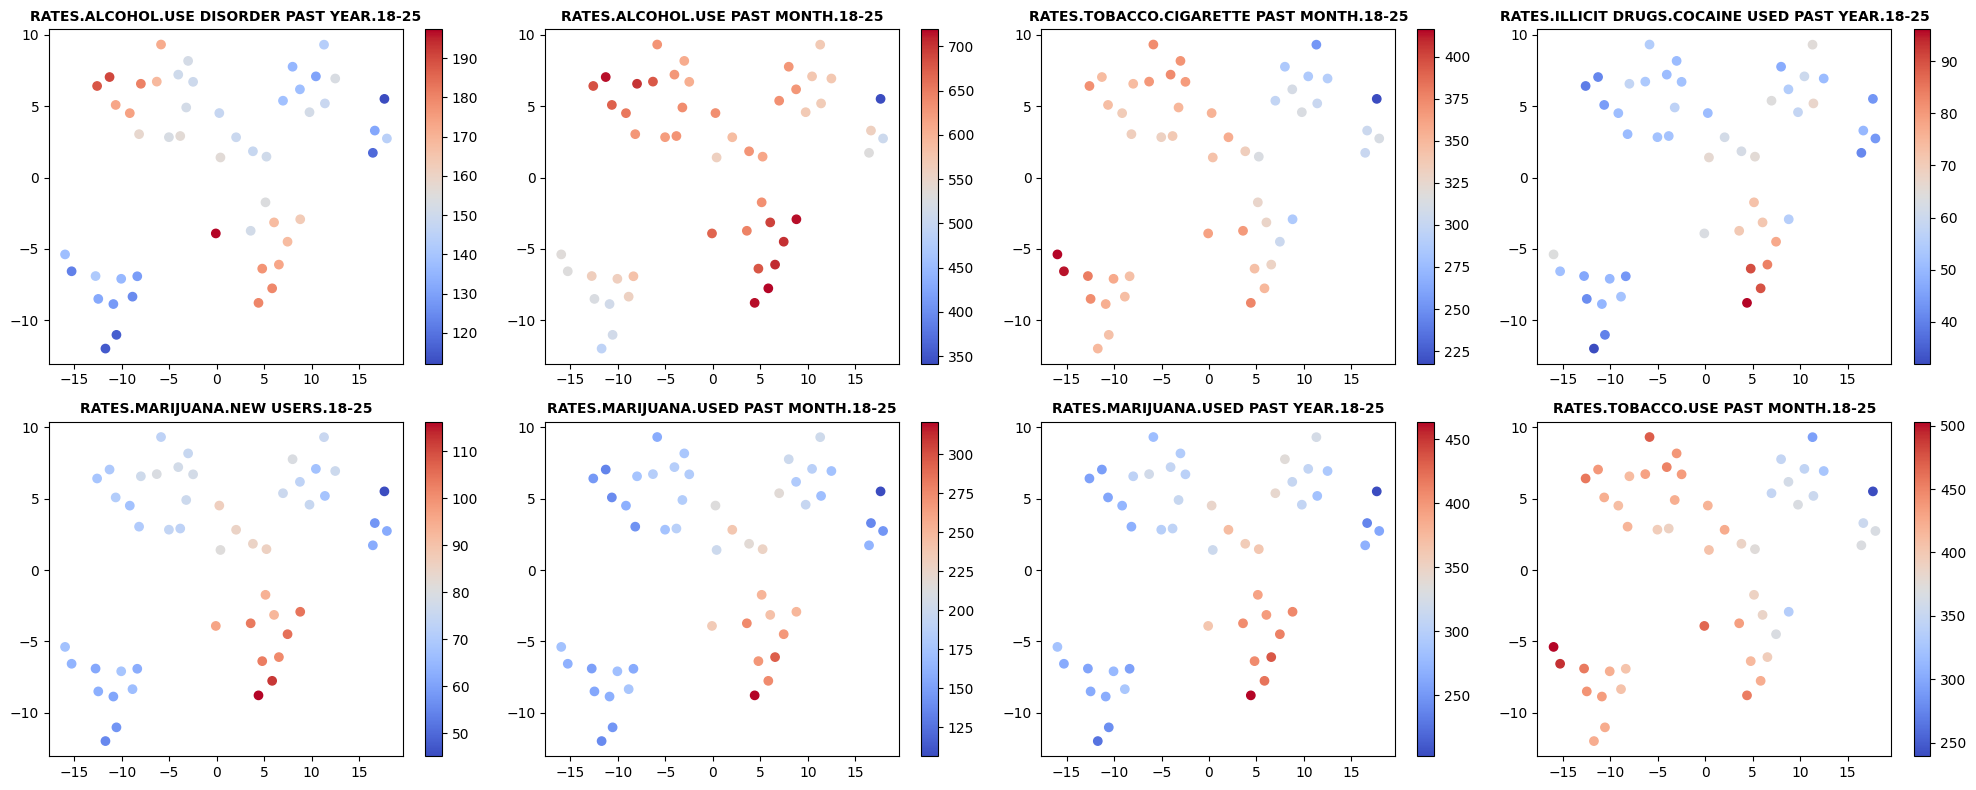

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
axes = axes.flatten()
for i, col in zip(range(df.drop(columns='State').shape[1]), df.columns[1:]):
    ax = axes[i]
    sc = ax.scatter(df_tsne['x'], df_tsne['y'], c=df[col], cmap='coolwarm')
    fig.colorbar(sc, ax=ax)
    ax.set_title(col.upper(), fontsize=10, fontweight='bold')
fig.tight_layout()
plt.show()

There does seem to be some association between the inherent clusters suggested by the t-SNE plot and the variables in the original dataset. First, for alcohol user disorder and similarly for alcohol usage in the past month, the top-left and bottom-right clusters have the highest rates. Second, for tobacco and cigarette usage, the top-left, bottom-left, and bottom-right plots have the highest rates. Lastly, for cocaine and marijuana usage, the bottom right cluster has the highest rates.

Often, t-SNE plots are used for interpreting whether there exists a clustering structure, the approximate shape of clusters, the approximate number of clusters, the approximate number of objects in each cluster, and whether or not clusters are separated in the original dataset. However, t-SNE plots, including the ones created for this analysis, do not accurately elucidate the distance between objects, the distance between clusters, the centroid or any other summary statistics of clusters, the sparsity of clusters, and the existence of noise or outliers in the original dataset. Accordingly, the aforementioned characteristics should not be inferred from t-SNE, nor can t-SNE be used as corroborating evidence for these characteristics.

## 7. Clustering Algorithm Selection Motivation

Clustering Algorithm #1
Explain why you chose to use your first clustering algorithm to cluster this dataset. In your
explanation, you should discuss and consider:
* your research motivation
* the "ideal dataset properties" that this algorithm is designed to work best for (your anaylses
above should give you a sense as to whether many of these ideal properties are met or not).
Your explanation should give at least 3 distinct reasons.
HINT: I OFTEN FIND A LOT OF INCORRECT AI SLOP IN THESE ANSWERS IN THE PAST. BE
CAREFUL.

Clustering Algorithm #2
Explain why you chose to use your first clustering algorith to cluster this dataset. In your
explanation, you should discuss and consider:
* your research motivation
* the "ideal dataset properties" that this algorithm is designed to work best for (your anaylses
above should give you a sense as to whether many of these ideal properties are met or not).
Your explanation should give at least 3 distinct reasons.
HINT: I OFTEN FIND A LOT OF INCORRECT AI SLOP IN THESE ANSWERS IN THE PAST. BE
CAREFUL.

The second clustering algorithm we selected is fuzzy c-means. Based on the t-SNE plots, we determined that there were possibly overlapping clusters, which fuzzy c-means is able to identify. The t-SNE plots also suggest clusters are approximately balanced in size and have even sparsities, which are ideal properties for fuzzy c-means. Furthermore, based on the pairplots, there appears to be one outlier. Ideally, fuzzy c-means clustering will classify this outlier as its own distinct cluster while providing more nuanced information on the other states. The most significant hesitation for using this algorithm is that the t-SNE plots indicate that the clusters may not be completely spherical. However, they appear spherical enough that fuzzy c-means should still succeed. Fuzzy c-means will help identify which clusters of states are nearest each other, answering the research question of which states share drug abuse characteristics and therefore could benefit from shared programs for young adults. Compared to other algorithms like k-means, fuzzy c-means should provide the most nuanced information about the overlapping clusters and partial memberships, which are essential for legislators to implement the most effective programs and funding for each state. 

## 8. Clustering Algorithm #1 - Complete Linkage (lily, ben)



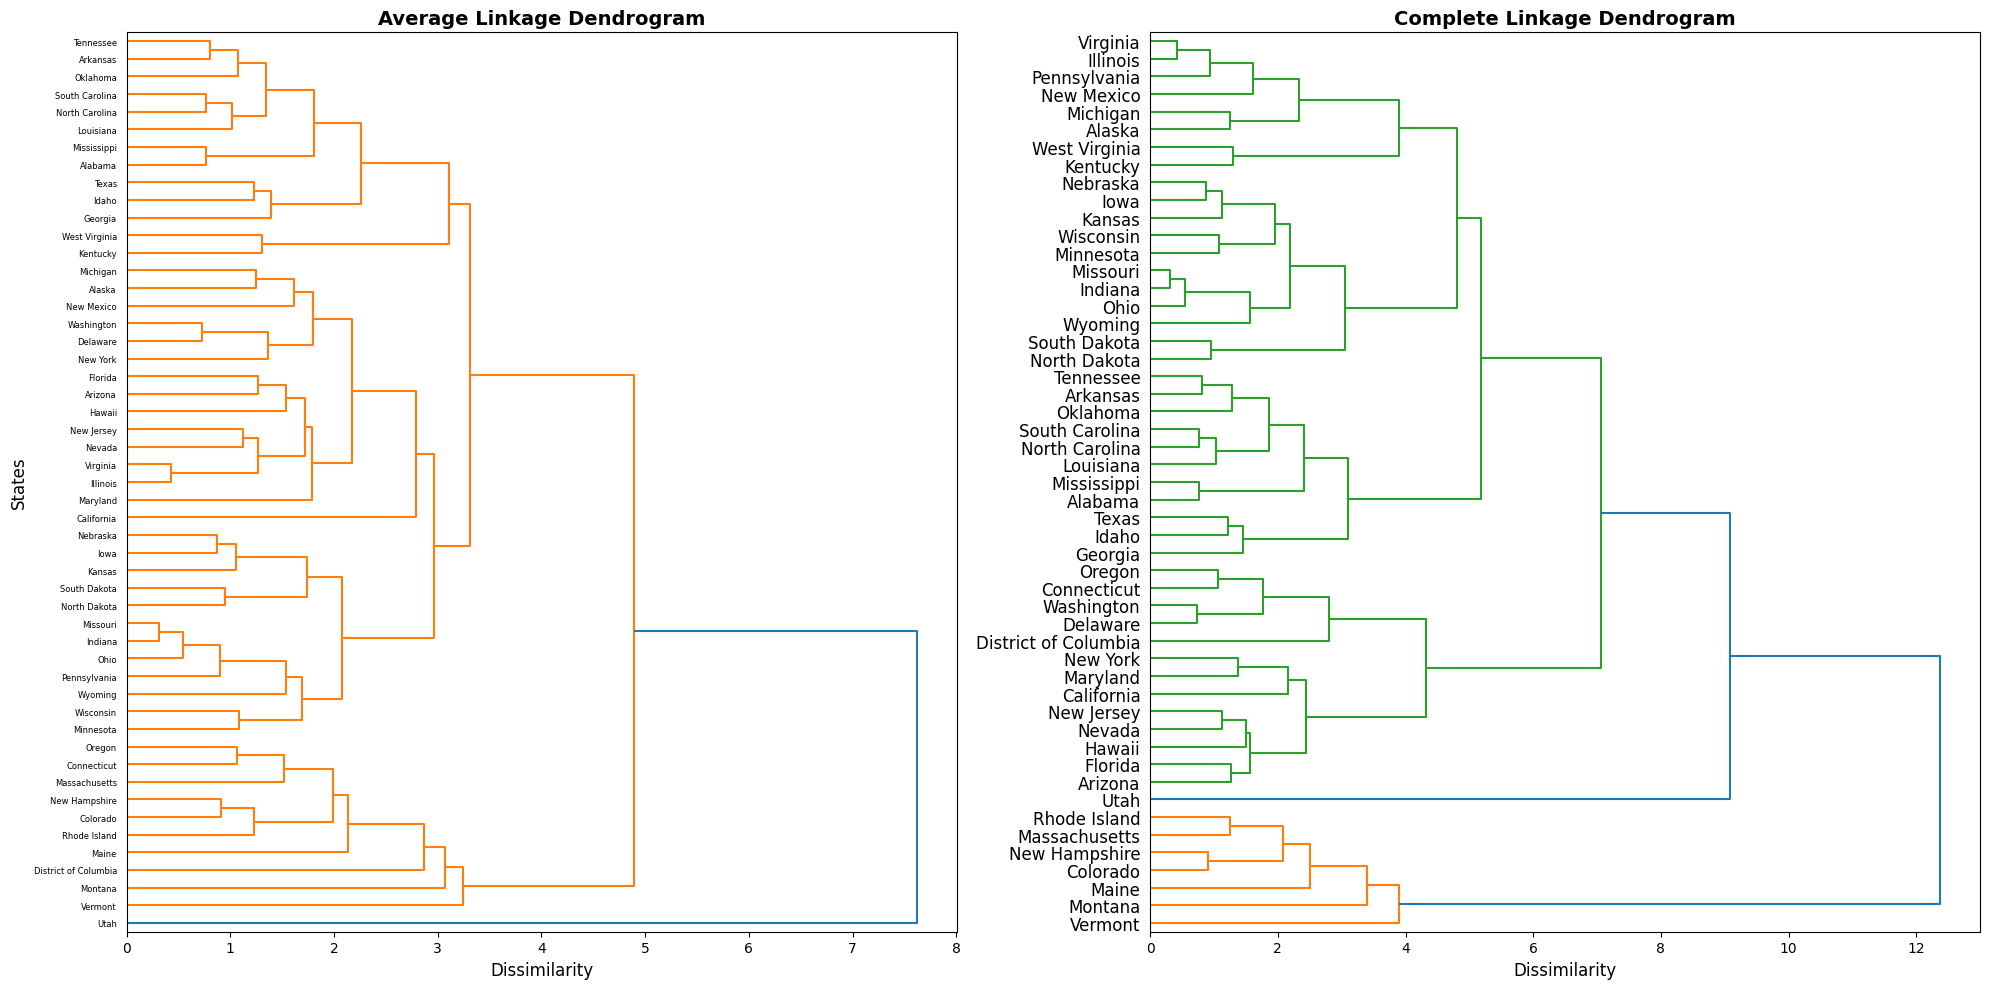

In [21]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
dm = pdist(X_scaled, metric='euclidean')

Z = linkage(dm, method='average')
d = dendrogram(Z, orientation='right', labels=states, ax=ax0)
ax0.set_xlabel('Dissimilarity', fontsize=12)
ax0.set_ylabel('States', fontsize=12)
ax0.set_title('Average Linkage Dendrogram', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

Z = linkage(dm, method='complete')
d = dendrogram(Z, orientation='right', labels=states, ax=ax1)
ax1.set_xlabel('Dissimilarity', fontsize=12)
ax1.set_title('Complete Linkage Dendrogram', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

fig.tight_layout()
plt.show()

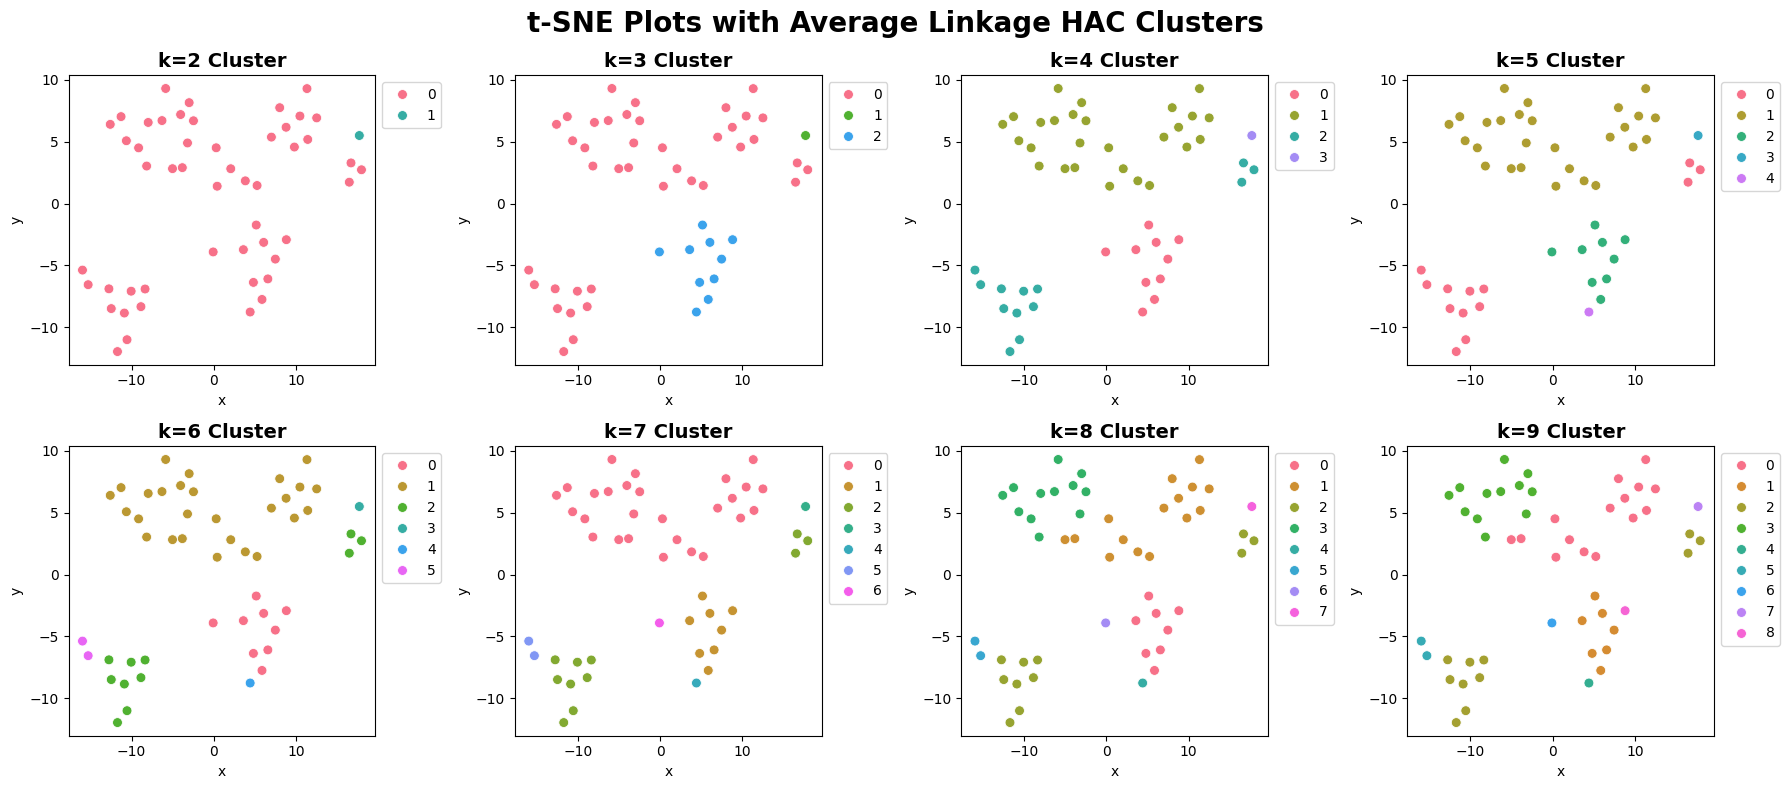

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()

for k in range(2, 10):
    hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='average')
    predicted_cluster = hac.fit_predict(X_scaled)
    ax = axes[k-2]

    sns.scatterplot(
        x='x', y='y',
        hue=predicted_cluster, palette=sns.color_palette("husl", k),
        data=df_tsne, s=50, ax=ax
    )

    ax.set_title(f'k={k} Cluster', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1, 1))

fig.suptitle('t-SNE Plots with Average Linkage HAC Clusters', fontsize=20, fontweight='bold')
fig.tight_layout()
plt.show()

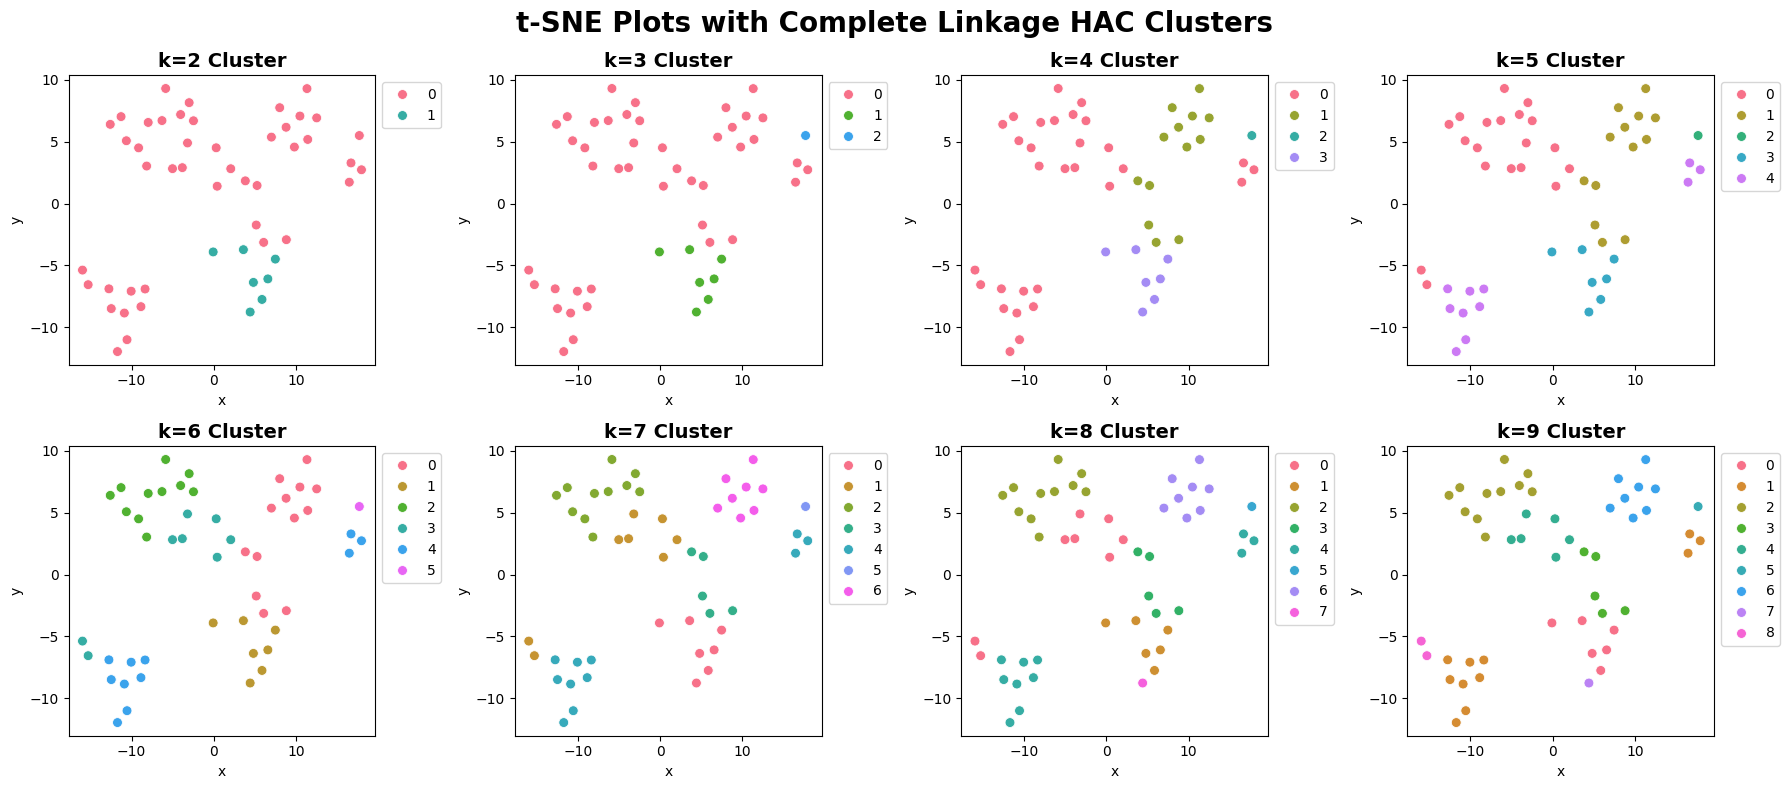

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()

for k in range(2, 10):
    hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
    predicted_cluster = hac.fit_predict(X_scaled)
    ax = axes[k-2]

    sns.scatterplot(
        x='x', y='y',
        hue=predicted_cluster, palette=sns.color_palette("husl", k),
        data=df_tsne, s=50, ax=ax
    )

    ax.set_title(f'k={k} Cluster', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1, 1))

fig.suptitle('t-SNE Plots with Complete Linkage HAC Clusters', fontsize=20, fontweight='bold')
fig.tight_layout()
plt.show()

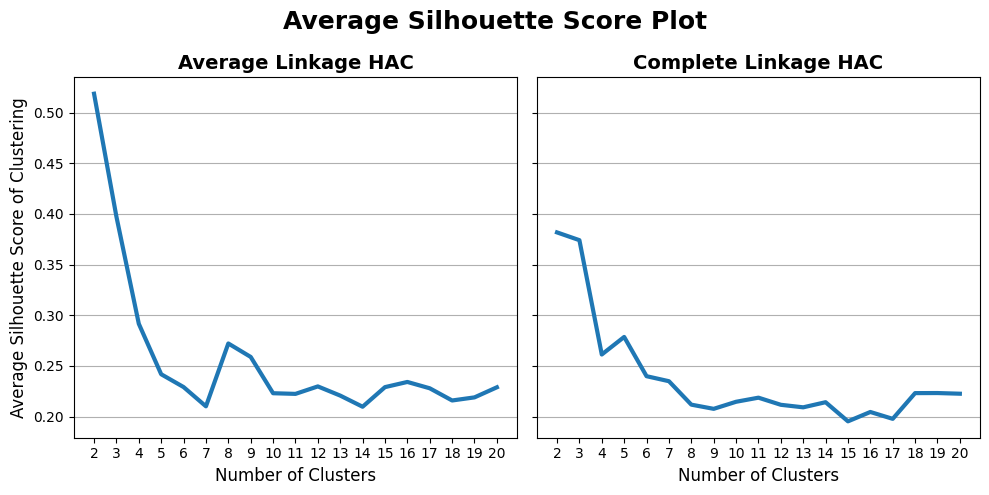

In [61]:
k = 20 # CLUSTERS
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
for ax, link in zip(axes, ['Average', 'Complete']):
    avg_ss = []
    for k in range(2, k+1):
        hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage=link.lower())
        y_pred = hac.fit_predict(X_scaled)
        avg_ss.append(silhouette_score(X_scaled, y_pred))

    ax.plot([_ for _ in range(2, k+1)], avg_ss, linewidth=3)
    ax.set_title(f'{link} Linkage HAC', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Clusters', fontsize=12)
    ax.set_xticks([i for i in range(2, k+1)])
    ax.yaxis.grid(True)
axes[0].set_ylabel('Average Silhouette Score of Clustering', fontsize=12)
fig.suptitle('Average Silhouette Score Plot', fontsize=18, fontweight='bold')
fig.tight_layout()
plt.show()

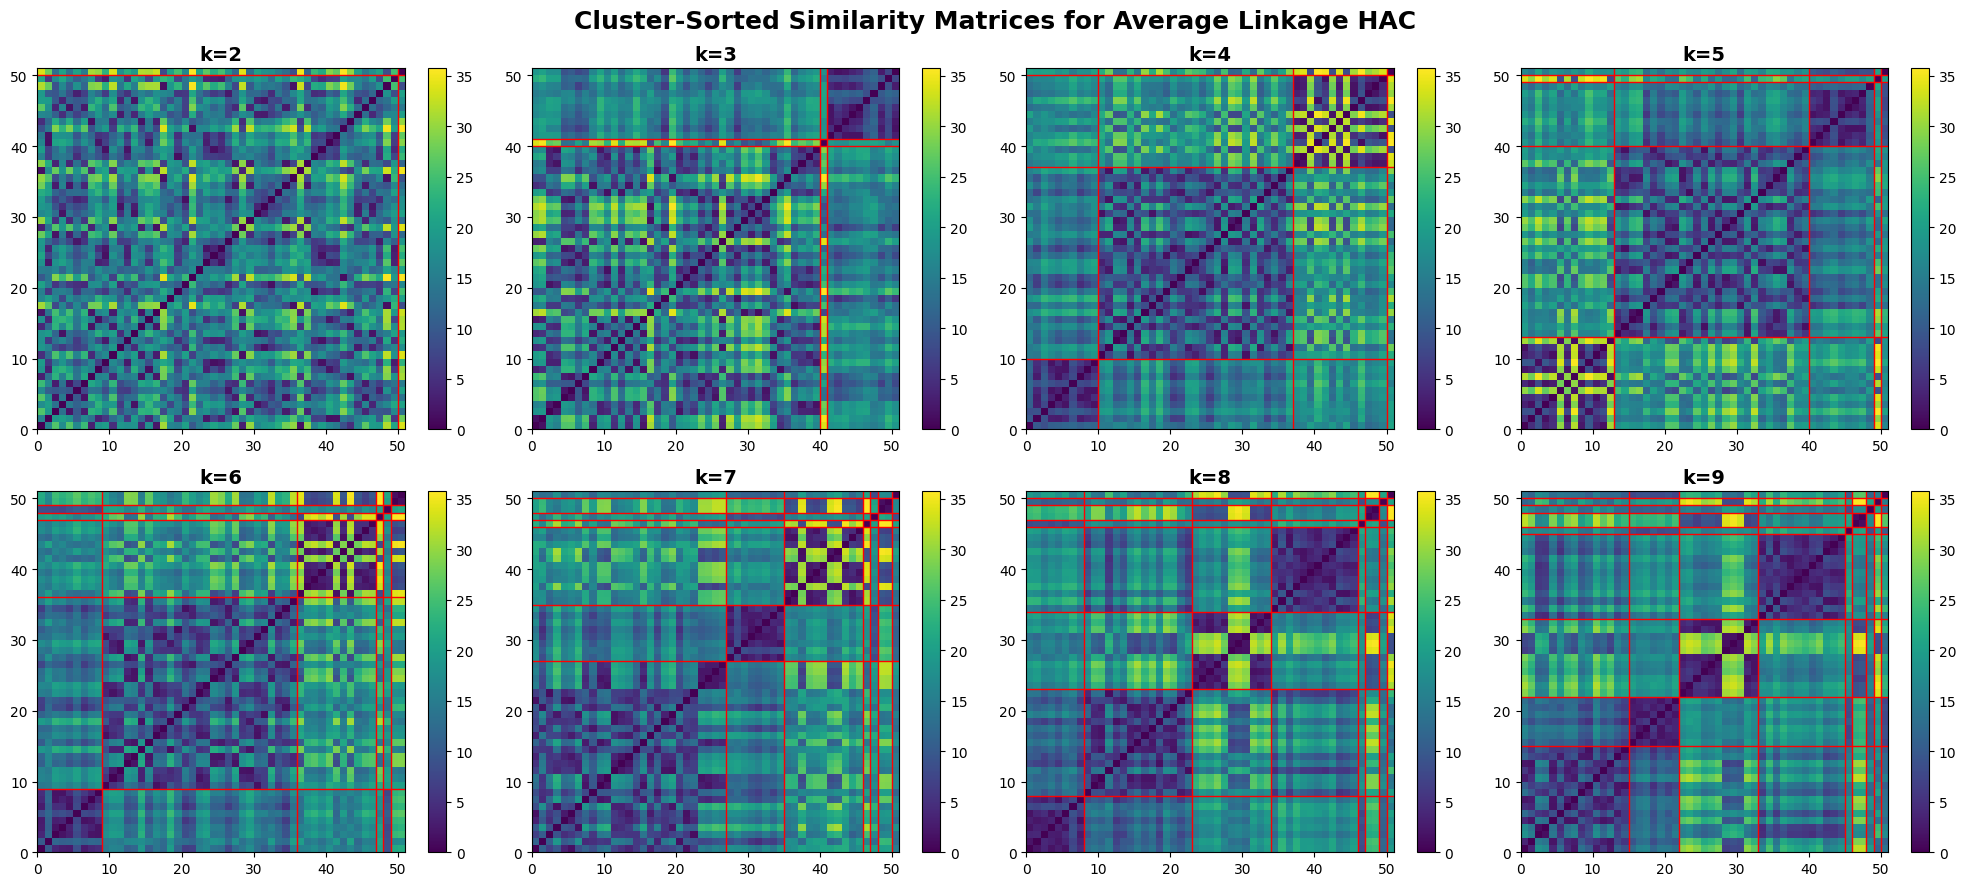

In [ ]:
k = 9 # CLUSTER
df_scaled_average = df_scaled.copy(deep=True)
for k in range(2, k+1):
    hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='average')
    df_scaled_average[f'predicted_cluster_k{k}'] = hac.fit_predict(X_scaled)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 9))
axes = axes.flatten()

for k in range(2, k+1):
    ax = axes[k-2]
    df_sort = df_scaled_average.sort_values(f'predicted_cluster_k{k}', ascending=True)
    dist_mat = squareform(pdist(df_sort.select_dtypes([int, float])))
    bounds = np.flatnonzero(np.diff(df_sort[f'predicted_cluster_k{k}'].to_numpy())) + 1
    im = ax.pcolormesh(dist_mat)
    fig.colorbar(im, ax=ax)
    N = len(df_sort)
    ax.vlines(bounds, 0, len(df_sort), colors='red', lw=2)
    ax.hlines(bounds, 0, len(df_sort), colors='red', lw=2)
    ax.set_xlim([0,N])
    ax.set_ylim([0,N])
    ax.set_title(f'k={k}', fontweight='bold', fontsize=14)

fig.suptitle('Cluster-Sorted Similarity Matrices for Average Linkage HAC', fontsize=18, fontweight='bold')
fig.tight_layout()
plt.show()

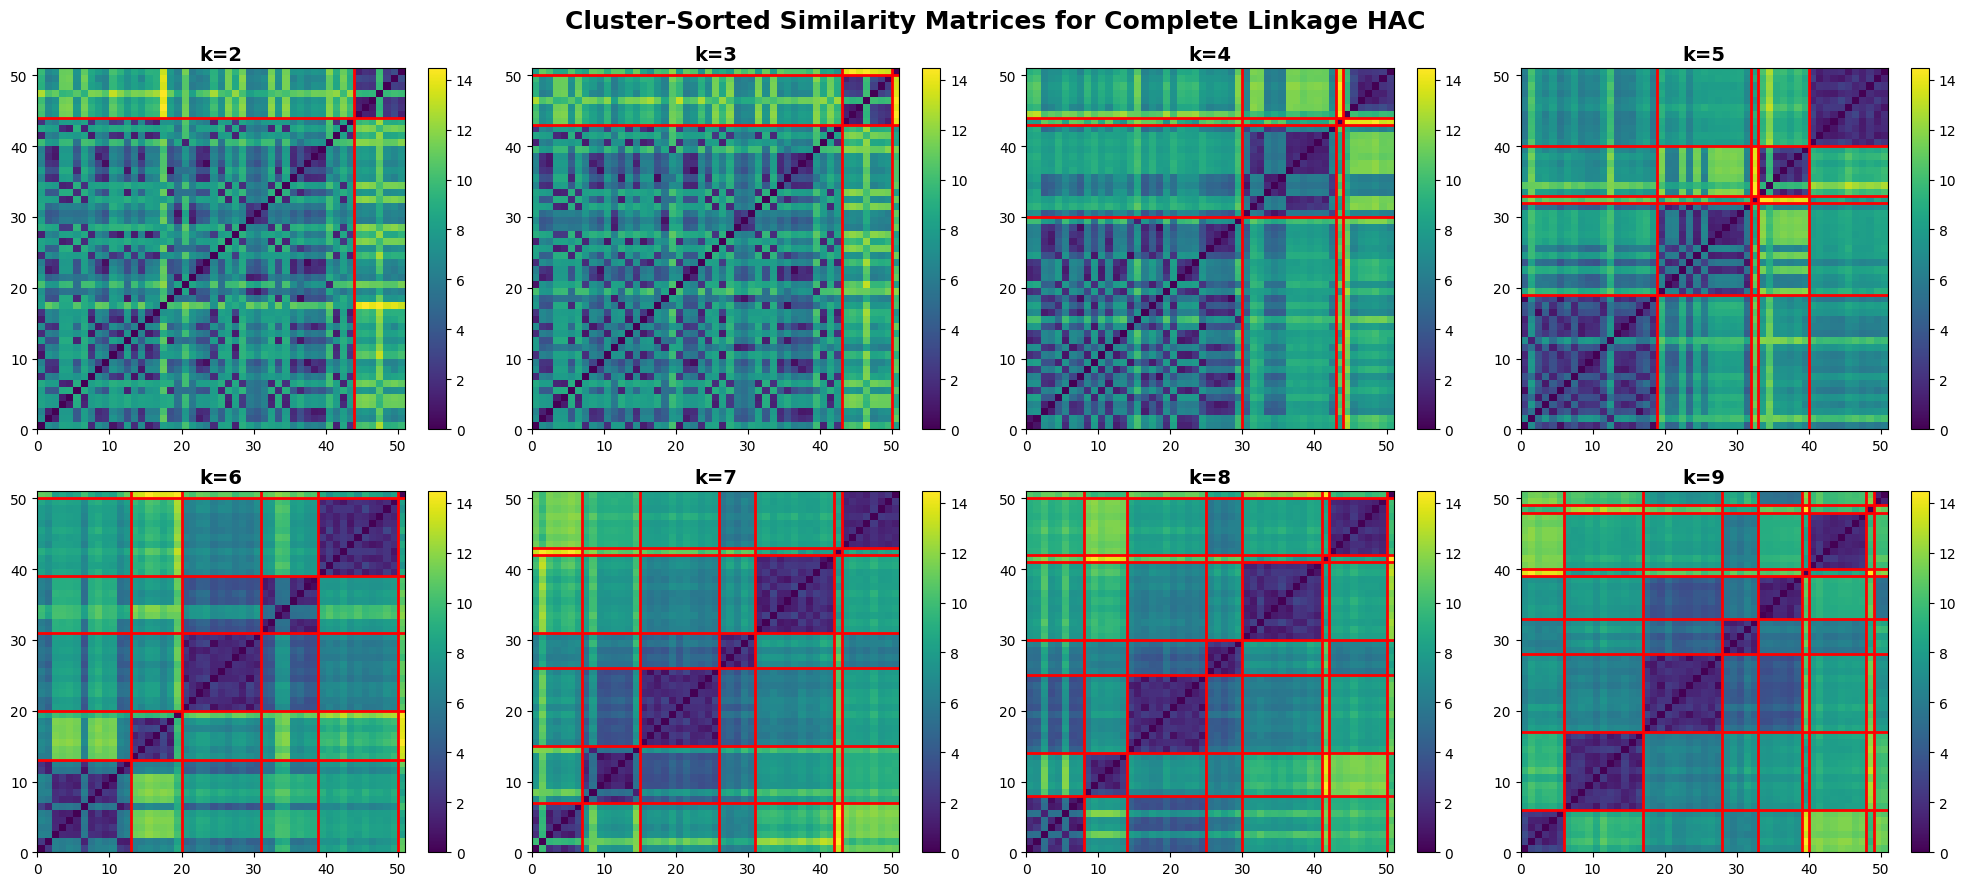

In [55]:
k = 9 # CLUSTER
df_scaled_complete = df_scaled.copy(deep=True)
for k in range(2, k+1):
    hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
    df_scaled_complete[f'predicted_cluster_k{k}'] = hac.fit_predict(X_scaled)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 9))
axes = axes.flatten()

for k in range(2, k+1):
    ax = axes[k-2]
    df_sort = df_scaled_complete.sort_values(f'predicted_cluster_k{k}', ascending=True)
    dist_mat = squareform(pdist(df_sort.select_dtypes([int, float])))
    bounds = np.flatnonzero(np.diff(df_sort[f'predicted_cluster_k{k}'].to_numpy())) + 1
    im = ax.pcolormesh(dist_mat)
    fig.colorbar(im, ax=ax)
    N = len(df_sort)
    ax.vlines(bounds, 0, len(df_sort), colors='red', lw=2)
    ax.hlines(bounds, 0, len(df_sort), colors='red', lw=2)
    ax.set_xlim([0,N])
    ax.set_ylim([0,N])
    ax.set_title(f'k={k}', fontweight='bold', fontsize=14)

fig.suptitle('Cluster-Sorted Similarity Matrices for Complete Linkage HAC', fontsize=18, fontweight='bold')
fig.tight_layout()
plt.show()

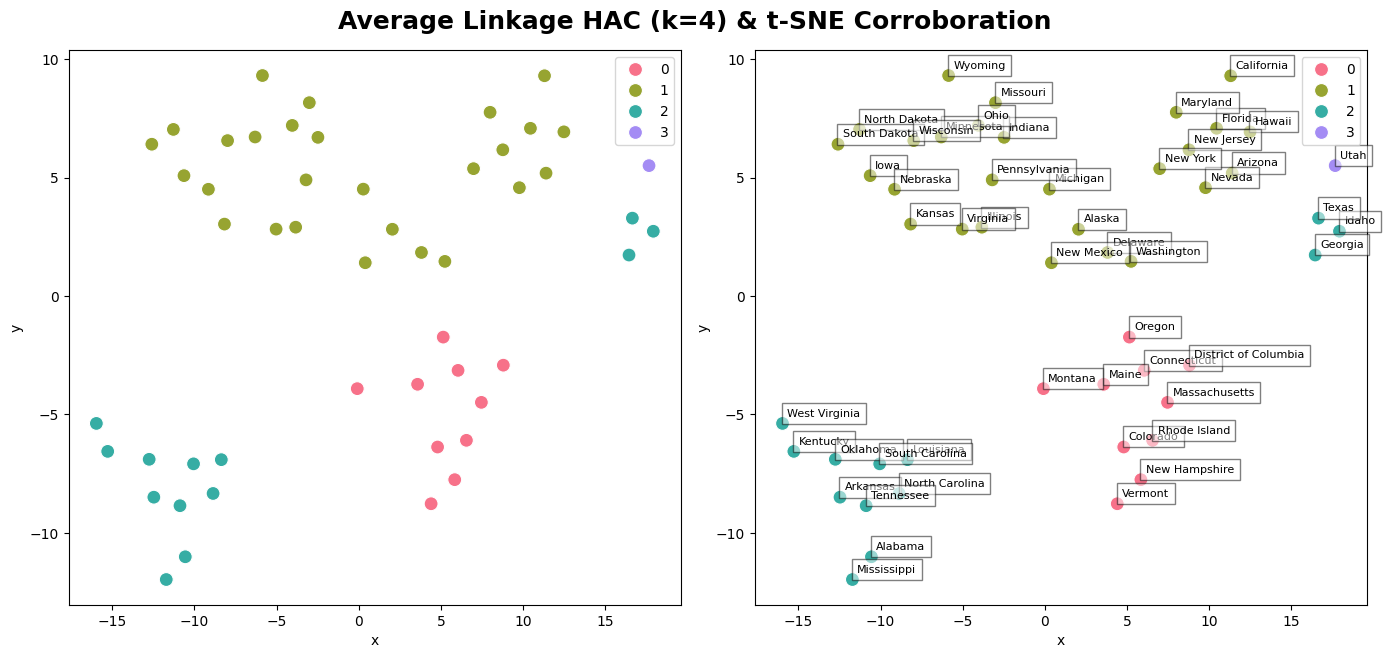

In [56]:
k = 4 # CLUSTERS
hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='average')
predicted_cluster = hac.fit_predict(X_scaled)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 10*(2/3)))

sns.scatterplot(
    x='x', y='y', hue=predicted_cluster,
    palette=sns.color_palette("husl", 4), data=df_tsne, ax=ax0, s=100
)

sns.scatterplot(x='x', y='y', hue=predicted_cluster, palette=sns.color_palette("husl", 4), data=df_tsne, ax=ax1, s=100)

for i in range(df_tsne.shape[0]):
    ax1.text(
        x=df_tsne.loc[i, 'x'] + 0.3, y=df_tsne.loc[i, 'y'] + 0.3,
        s=states[i],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )

fig.suptitle(f'Average Linkage HAC (k={k}) & t-SNE Corroboration', fontsize=18, fontweight='bold')
fig.tight_layout()
plt.show()

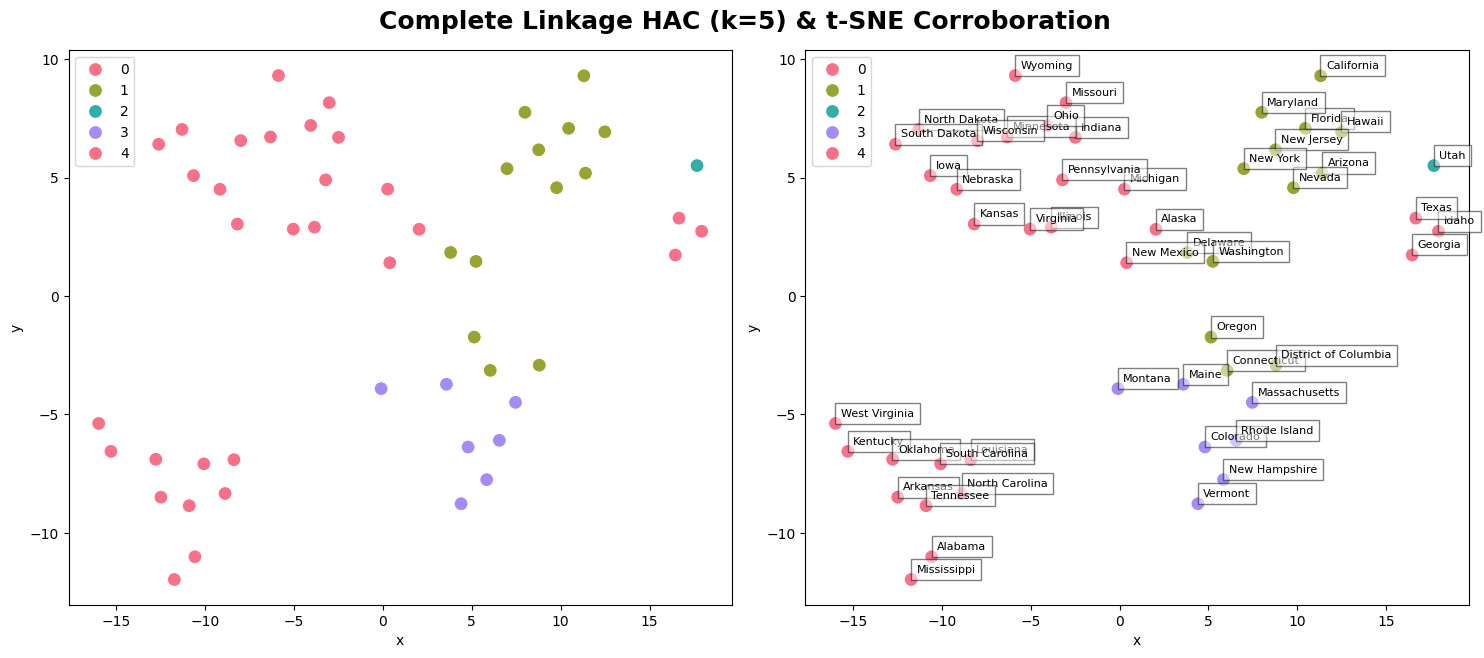

In [13]:
k = 5 # CLUSTERS
hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
predicted_cluster = hac.fit_predict(X_scaled)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10*(2/3)))

sns.scatterplot(
    x='x', y='y', hue=predicted_cluster,
    palette=sns.color_palette("husl", 4), data=df_tsne, ax=ax0, s=100
)

sns.scatterplot(x='x', y='y', hue=predicted_cluster, palette=sns.color_palette("husl", 4), data=df_tsne, ax=ax1, s=100)

for i in range(df_tsne.shape[0]):
    ax1.text(
        x=df_tsne.loc[i, 'x'] + 0.3, y=df_tsne.loc[i, 'y'] + 0.3,
        s=states[i],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )

fig.suptitle(f'Complete Linkage HAC (k={k}) & t-SNE Corroboration', fontsize=18, fontweight='bold')
fig.tight_layout()
plt.show()

## 9. Clustering Algorithm #2 - Fuzzy c-Means (jake, sydney)

### Fuzzy c-Means Elbow Plots

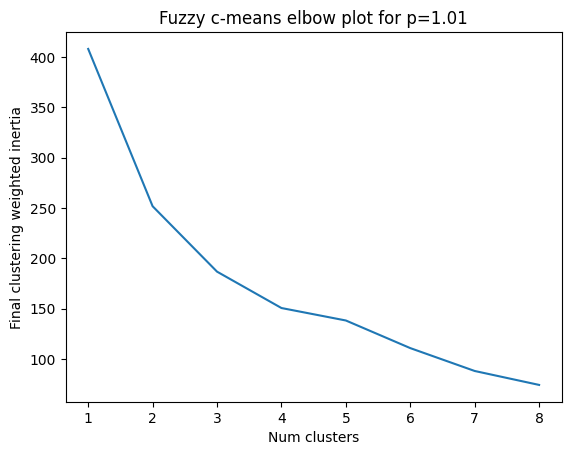

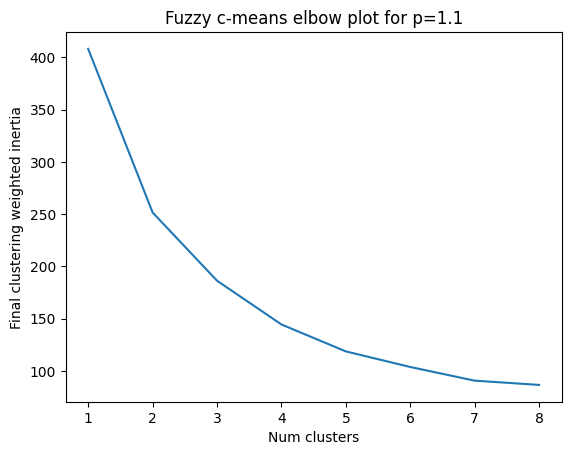

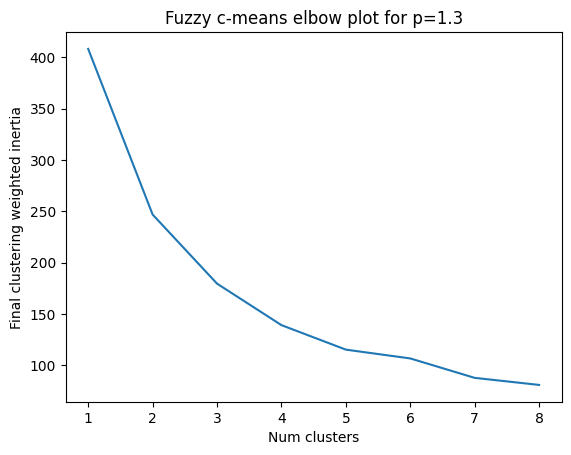

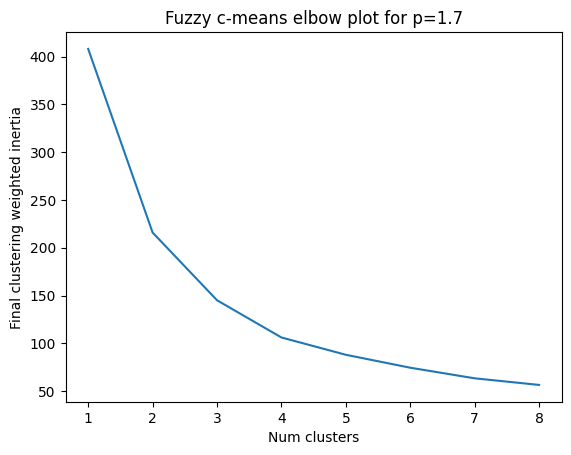

In [ ]:
for p in [1.01, 1.1, 1.3, 1.7]:
    inertias = []
    for c in range(1,9):
        centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
        inertias.append(history[len(history) - 1])

    plt.plot(range(1,9), inertias)
    plt.xlabel('Num clusters')
    plt.ylabel('Final clustering weighted inertia')
    plt.title(f'Fuzzy c-means elbow plot for p={p}')
    plt.show()   

### Fuzzy c-Means t-SNE Plot Corroboration

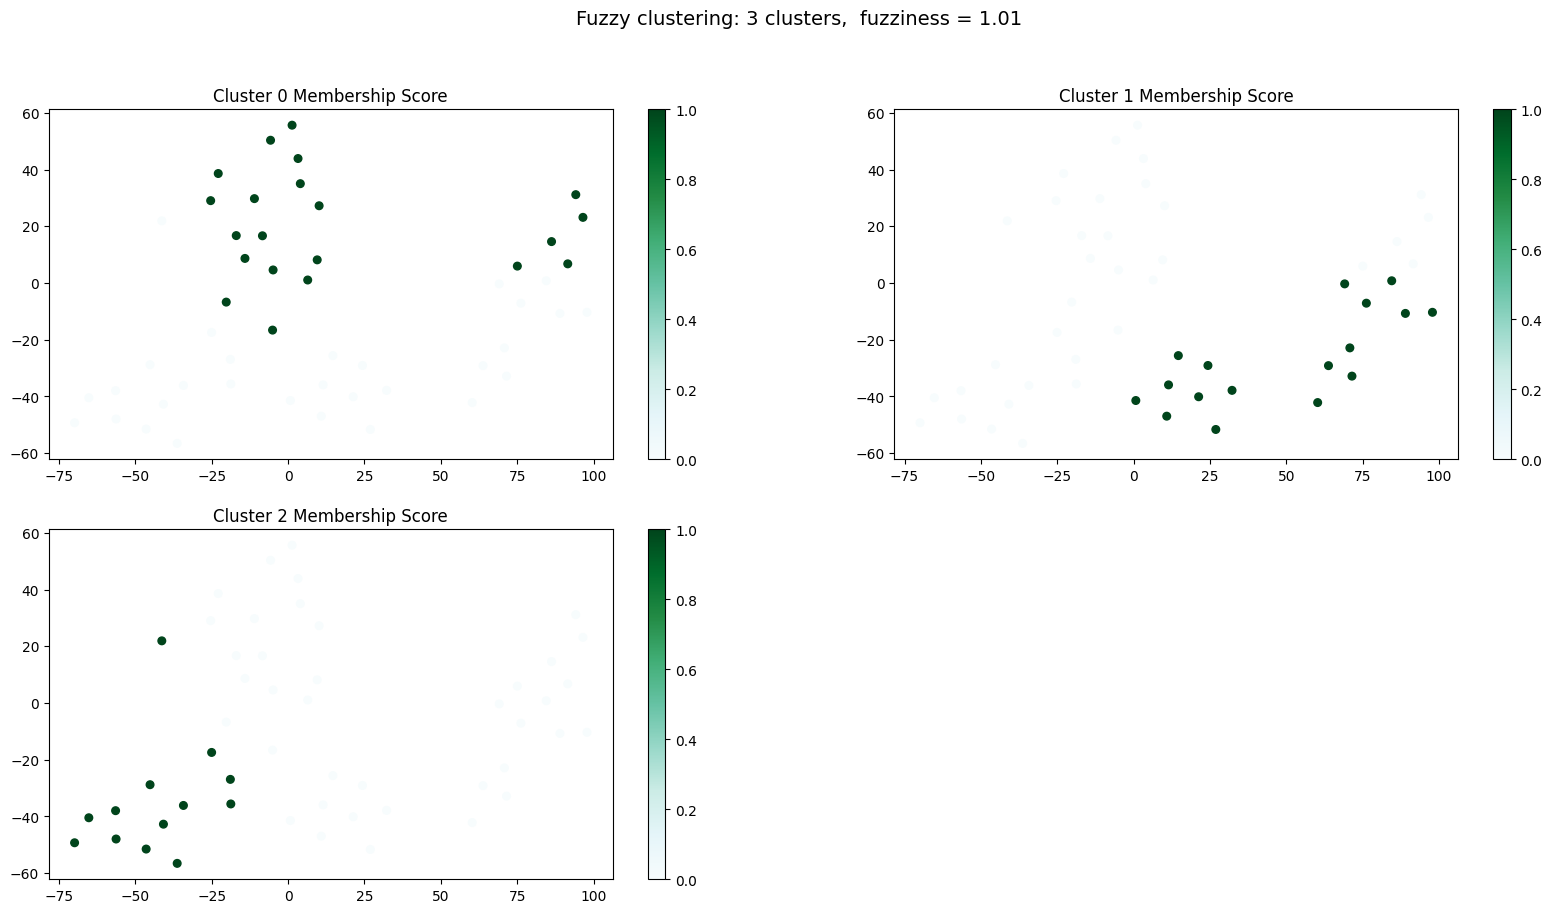

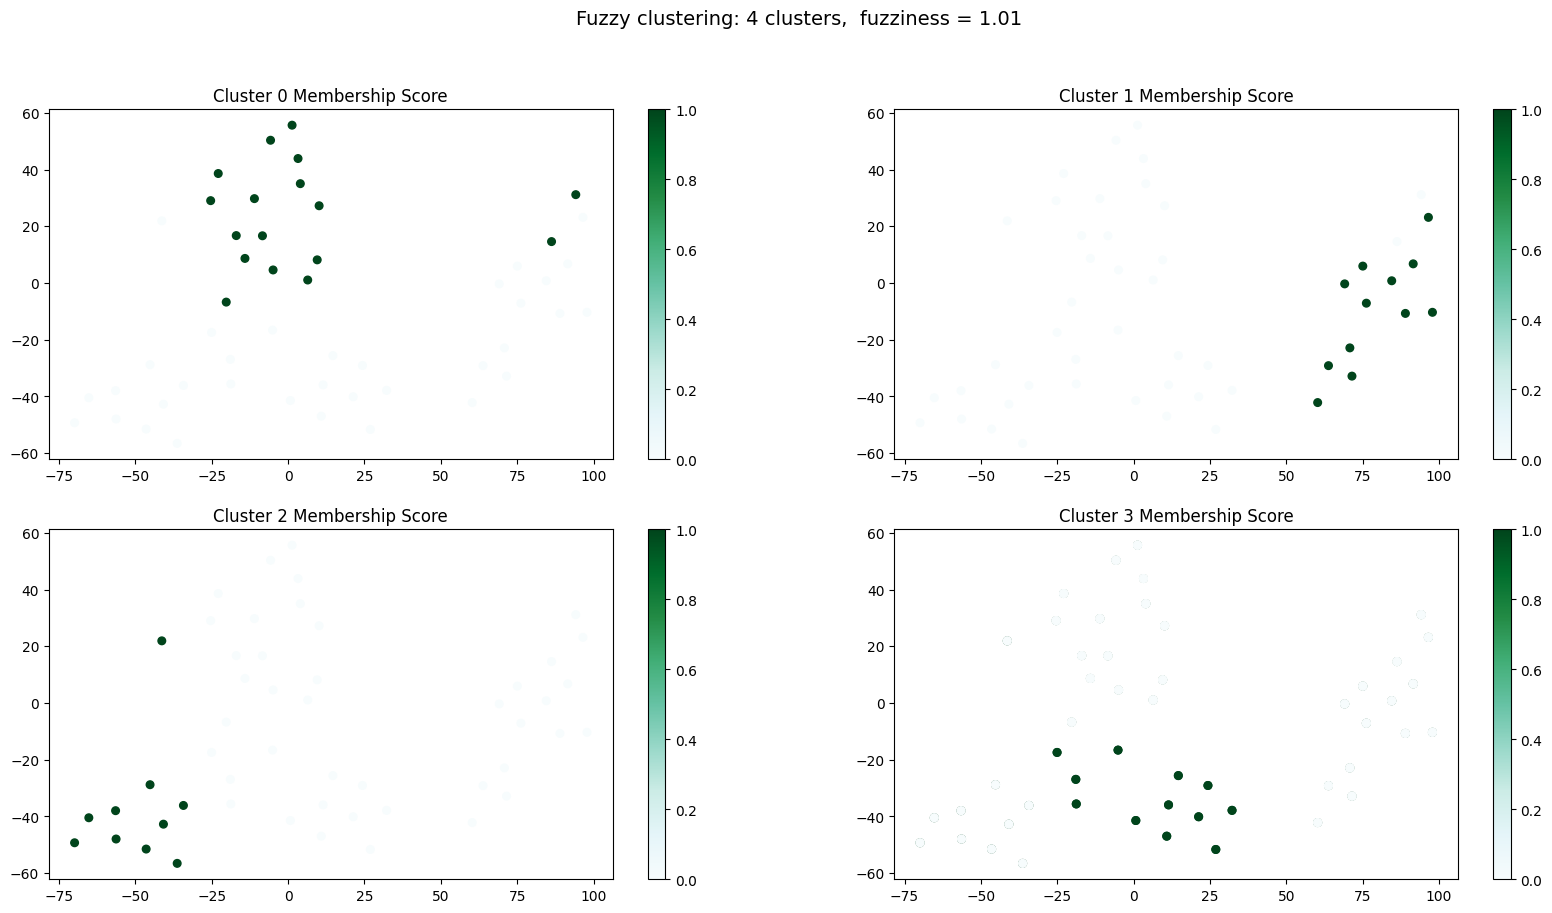

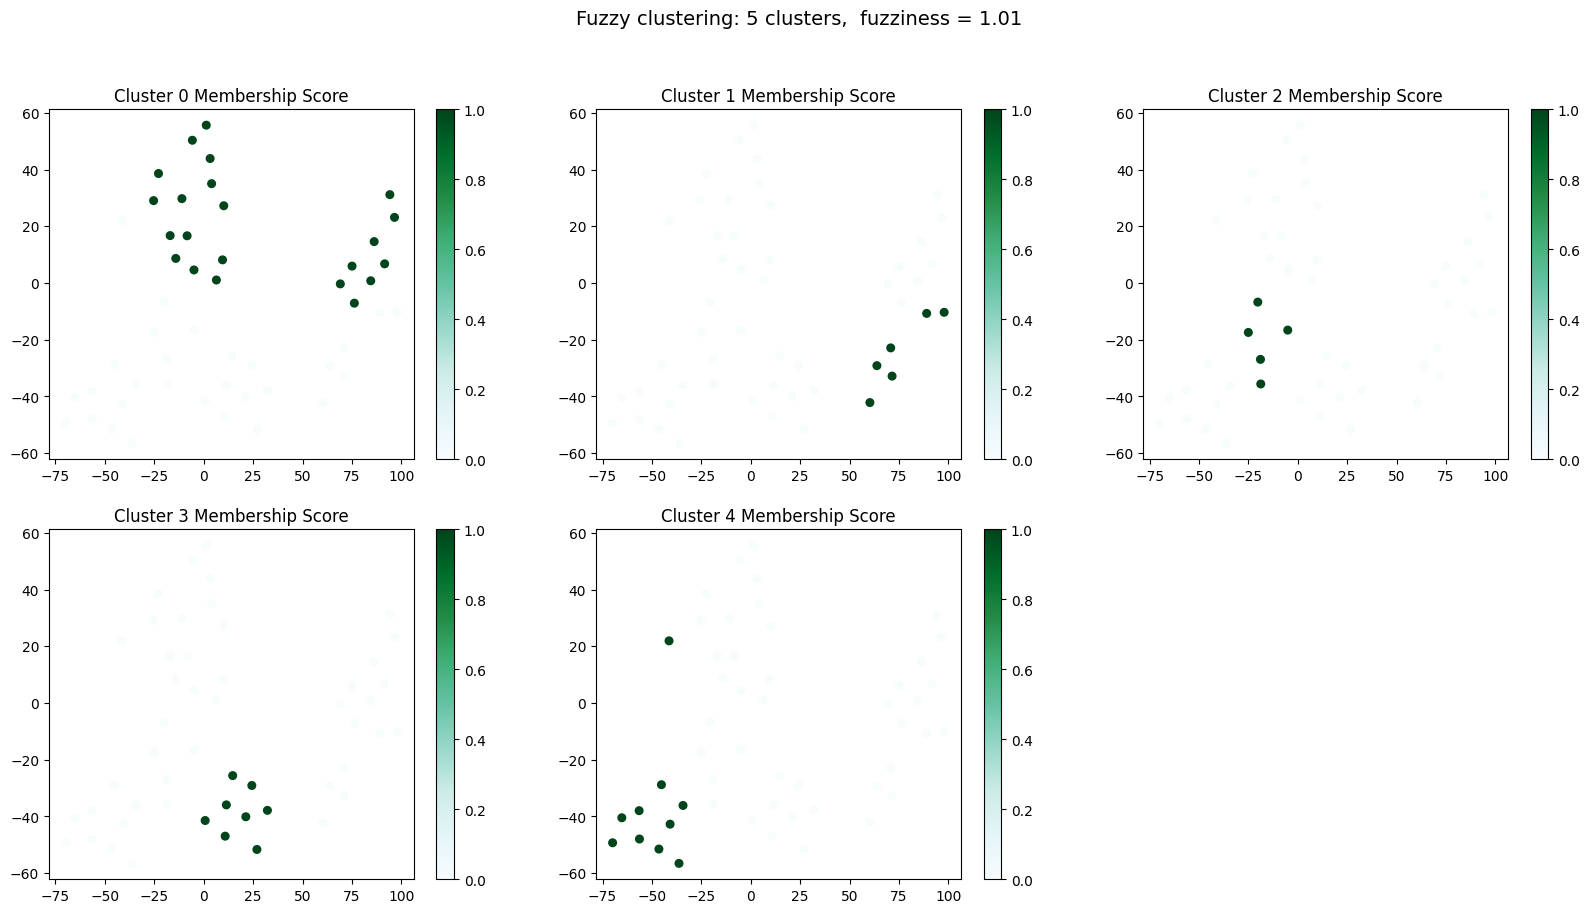

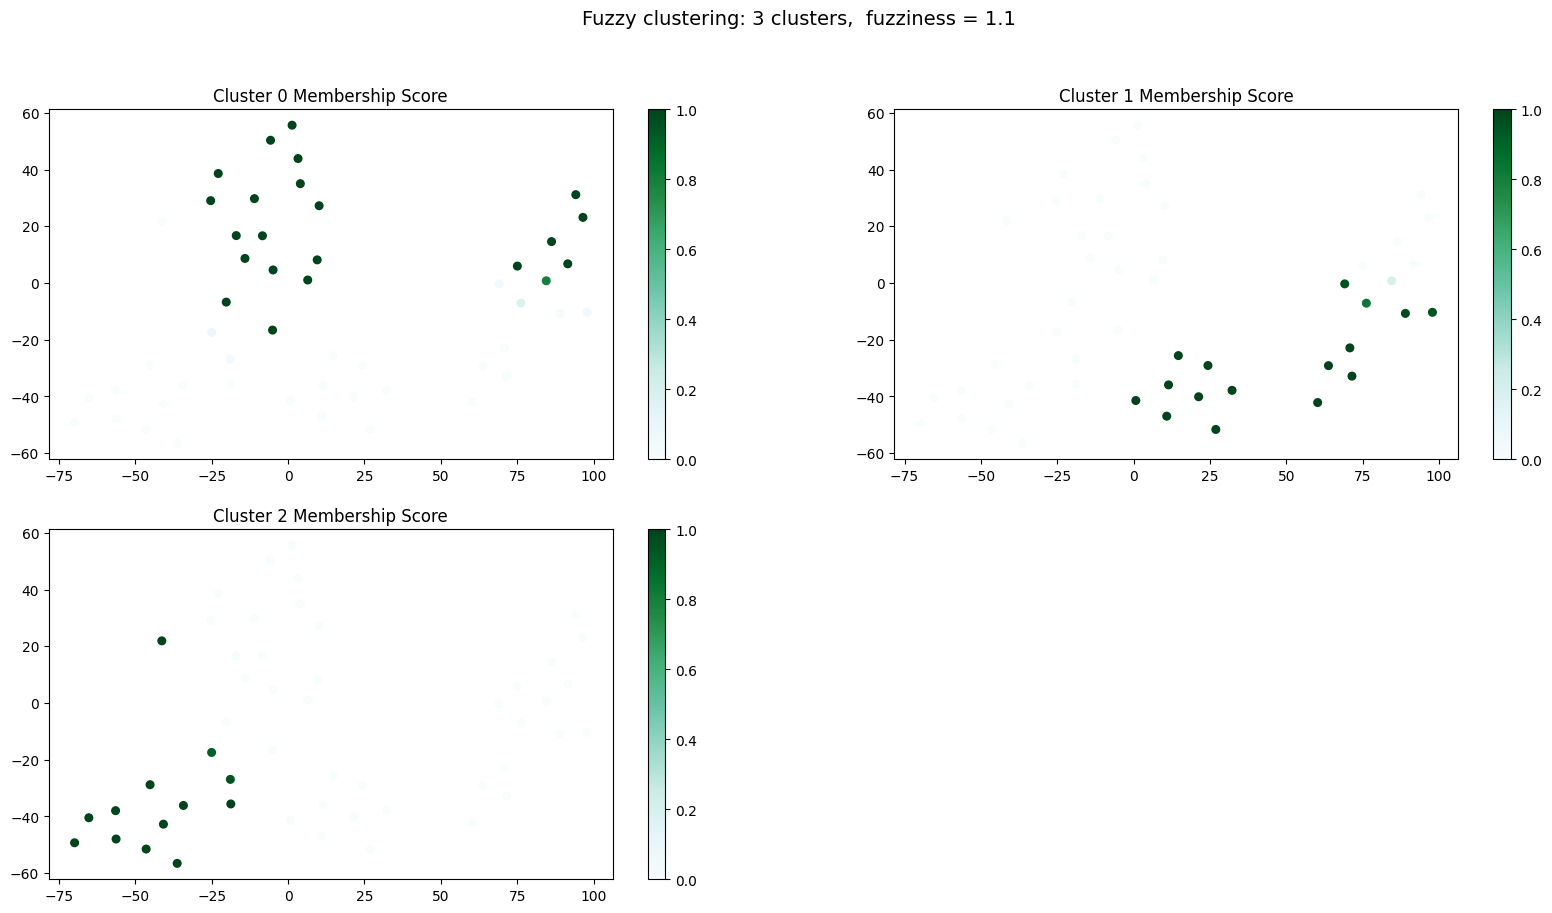

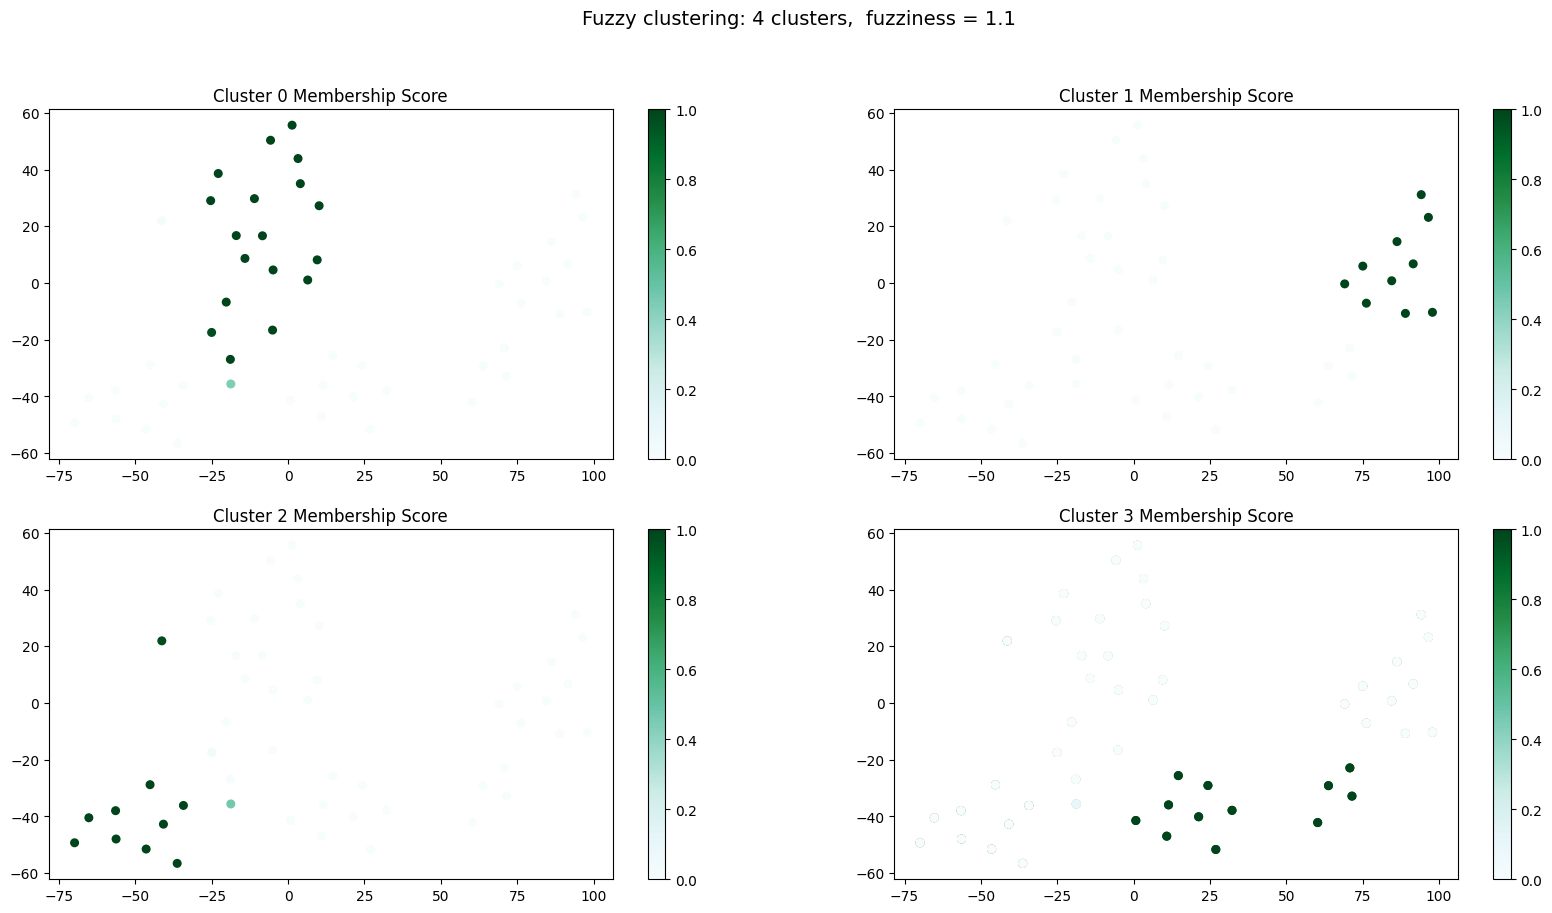

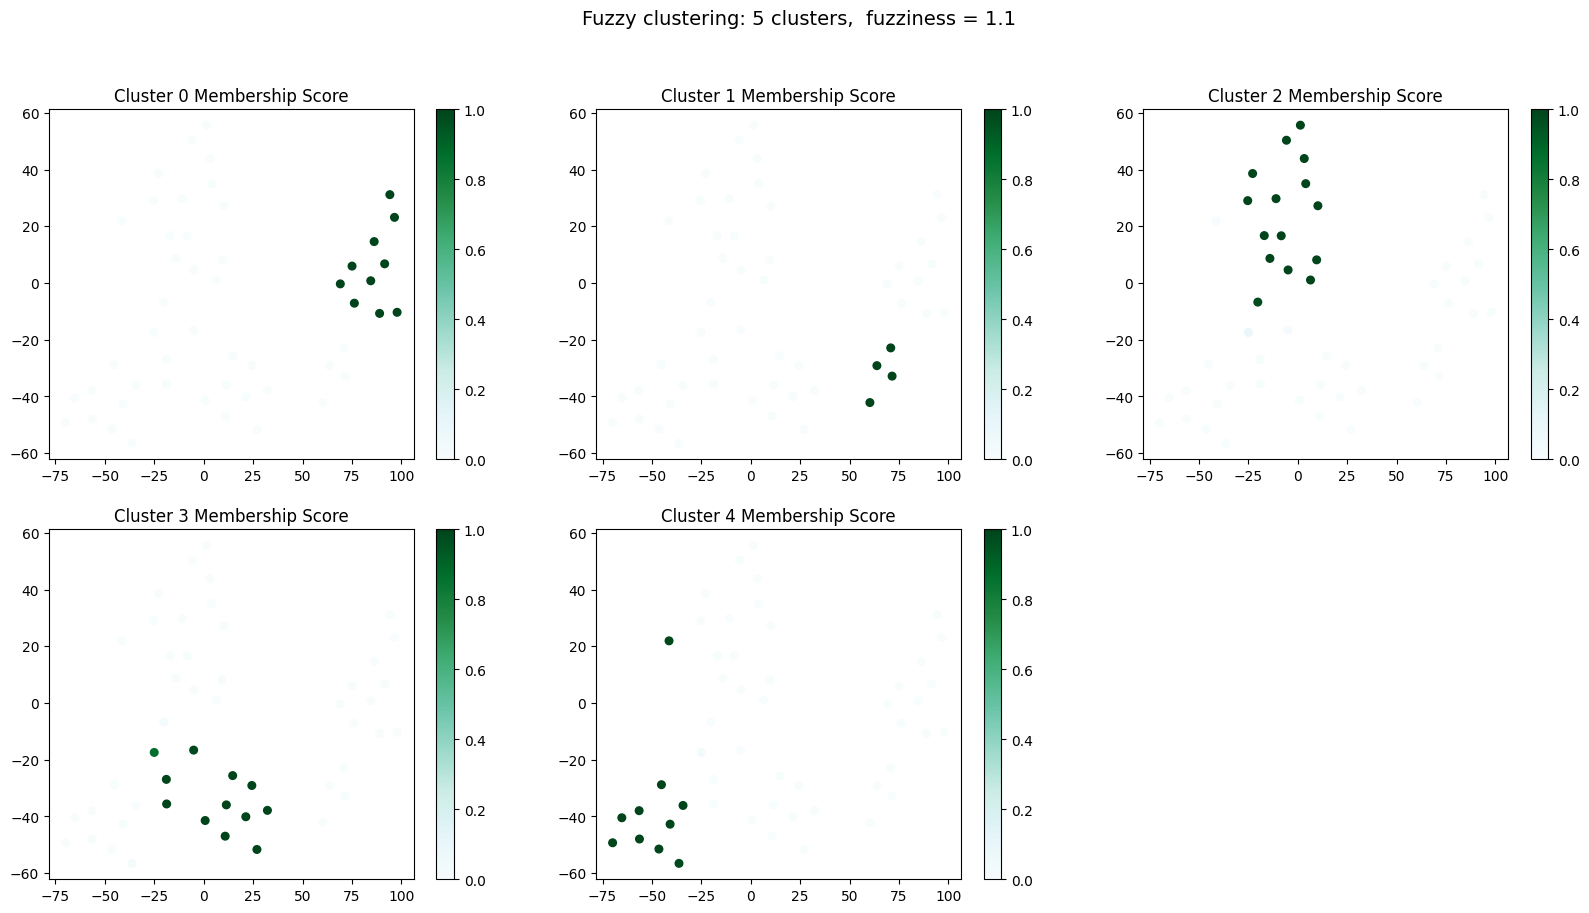

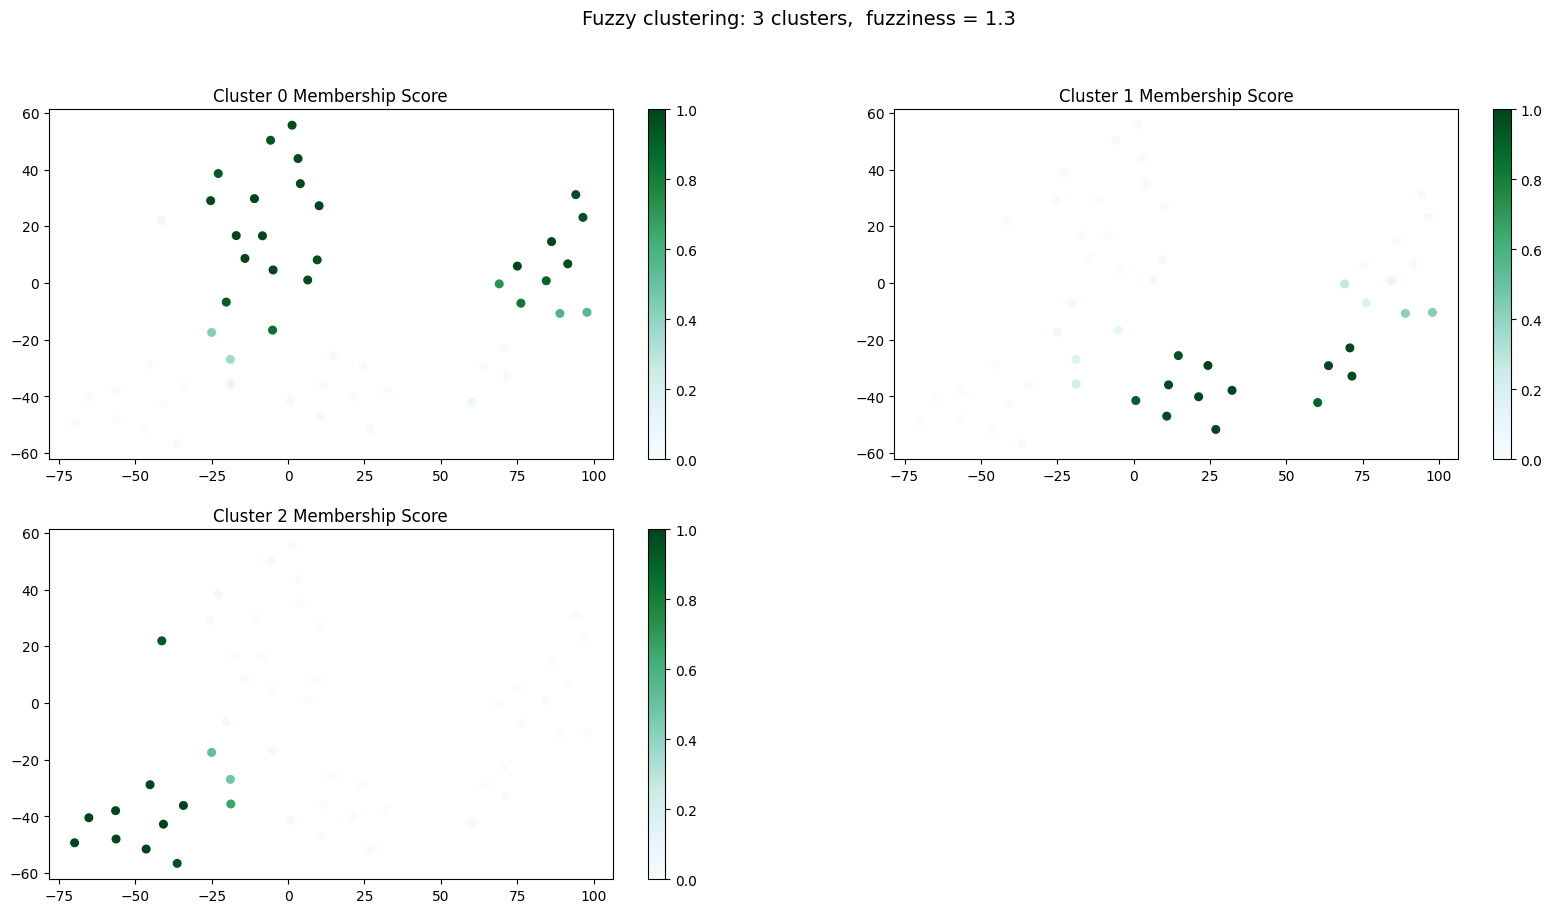

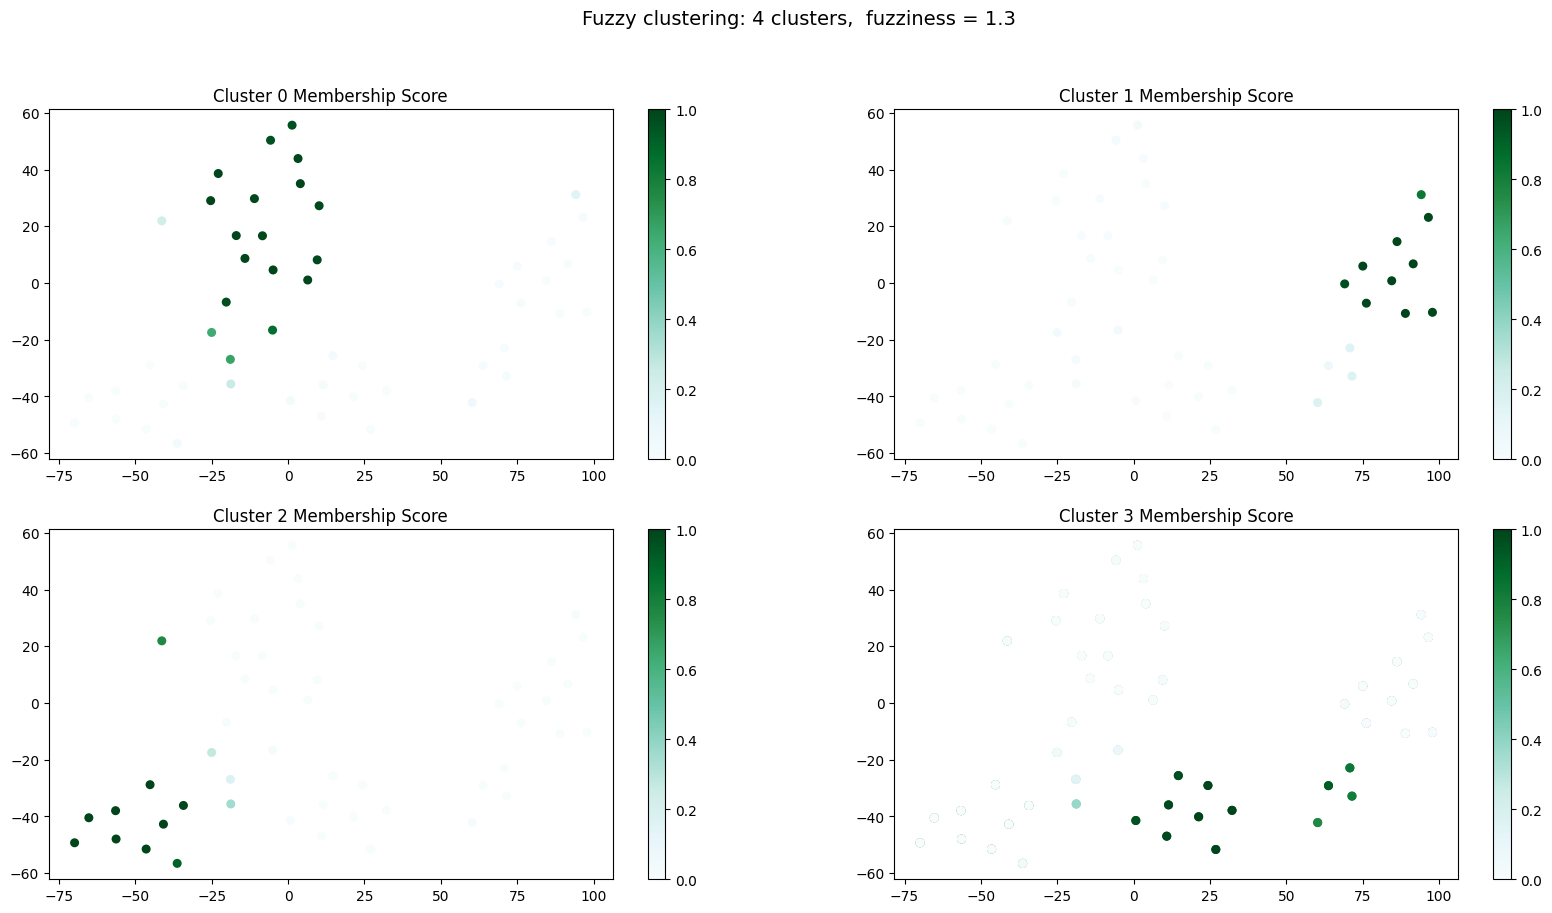

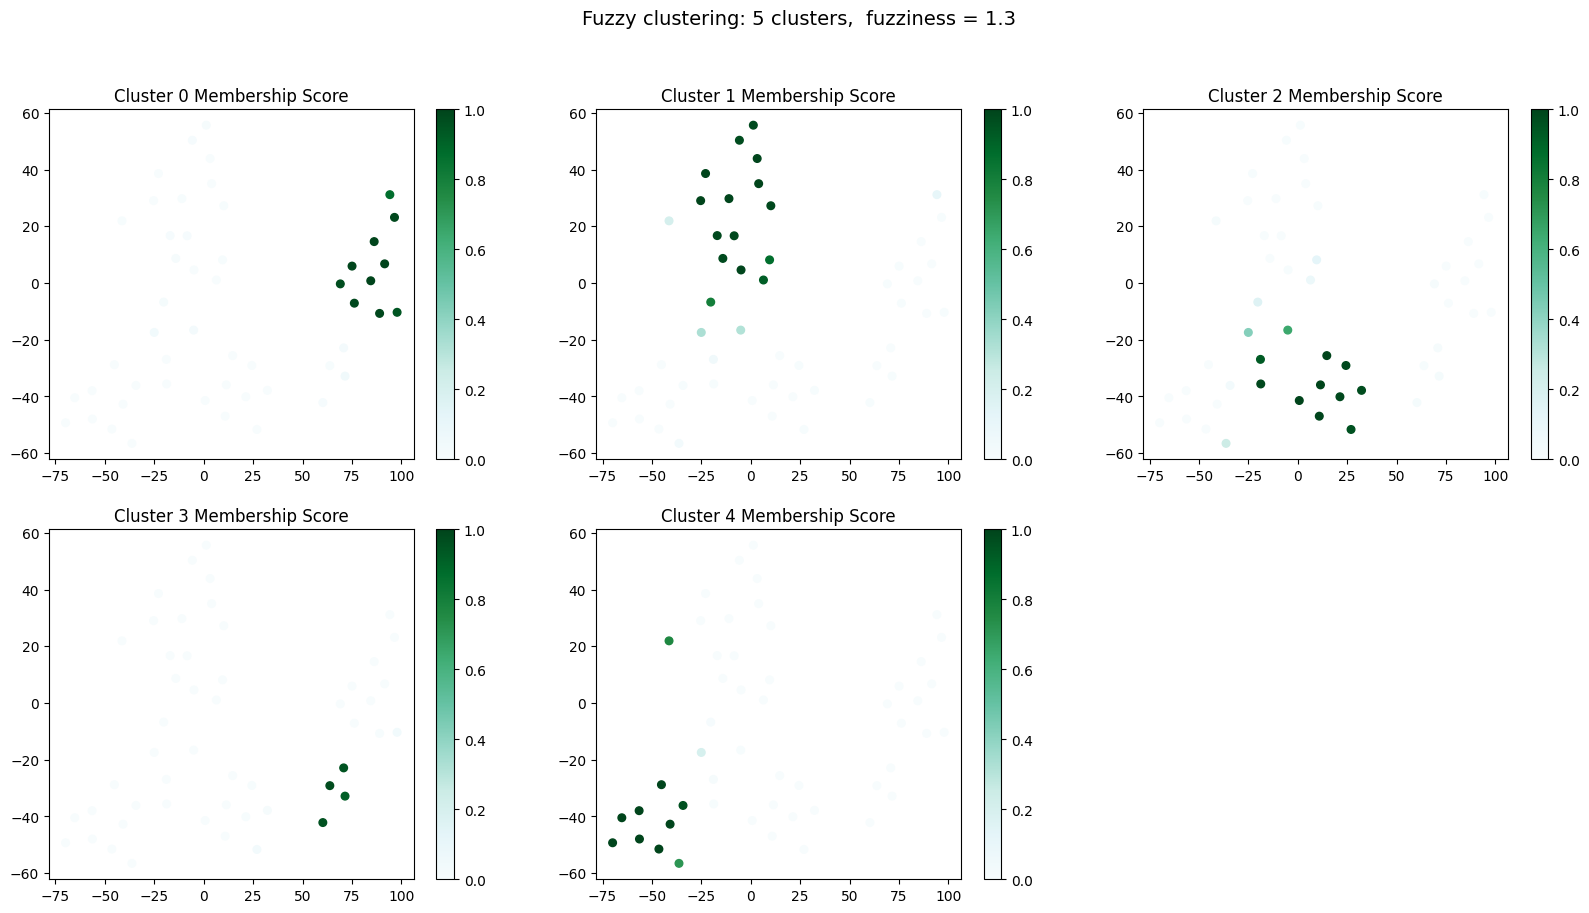

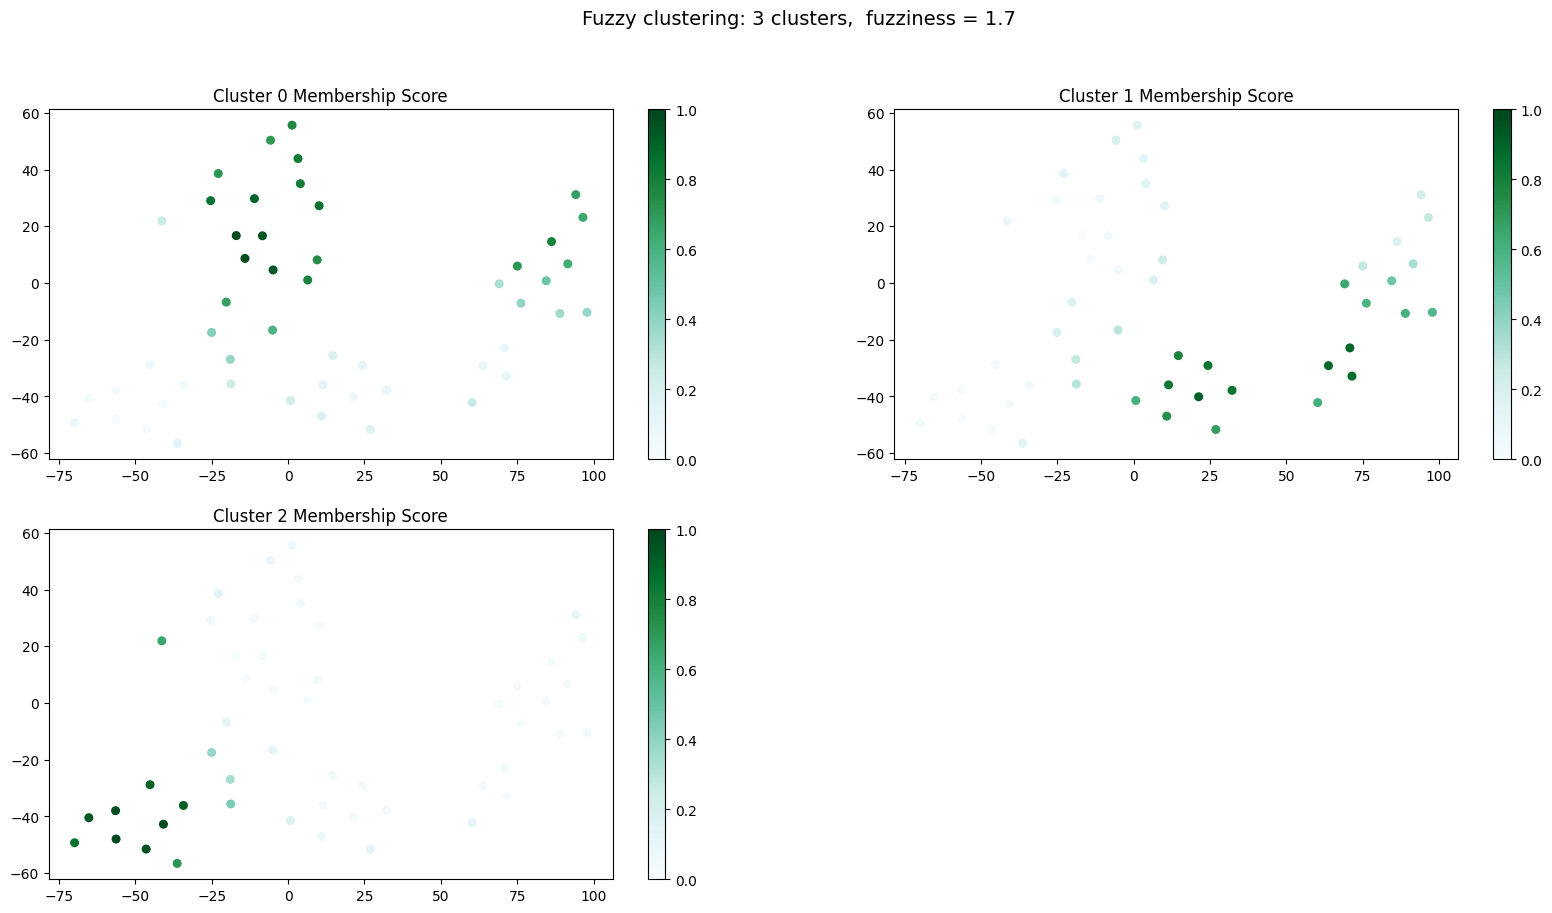

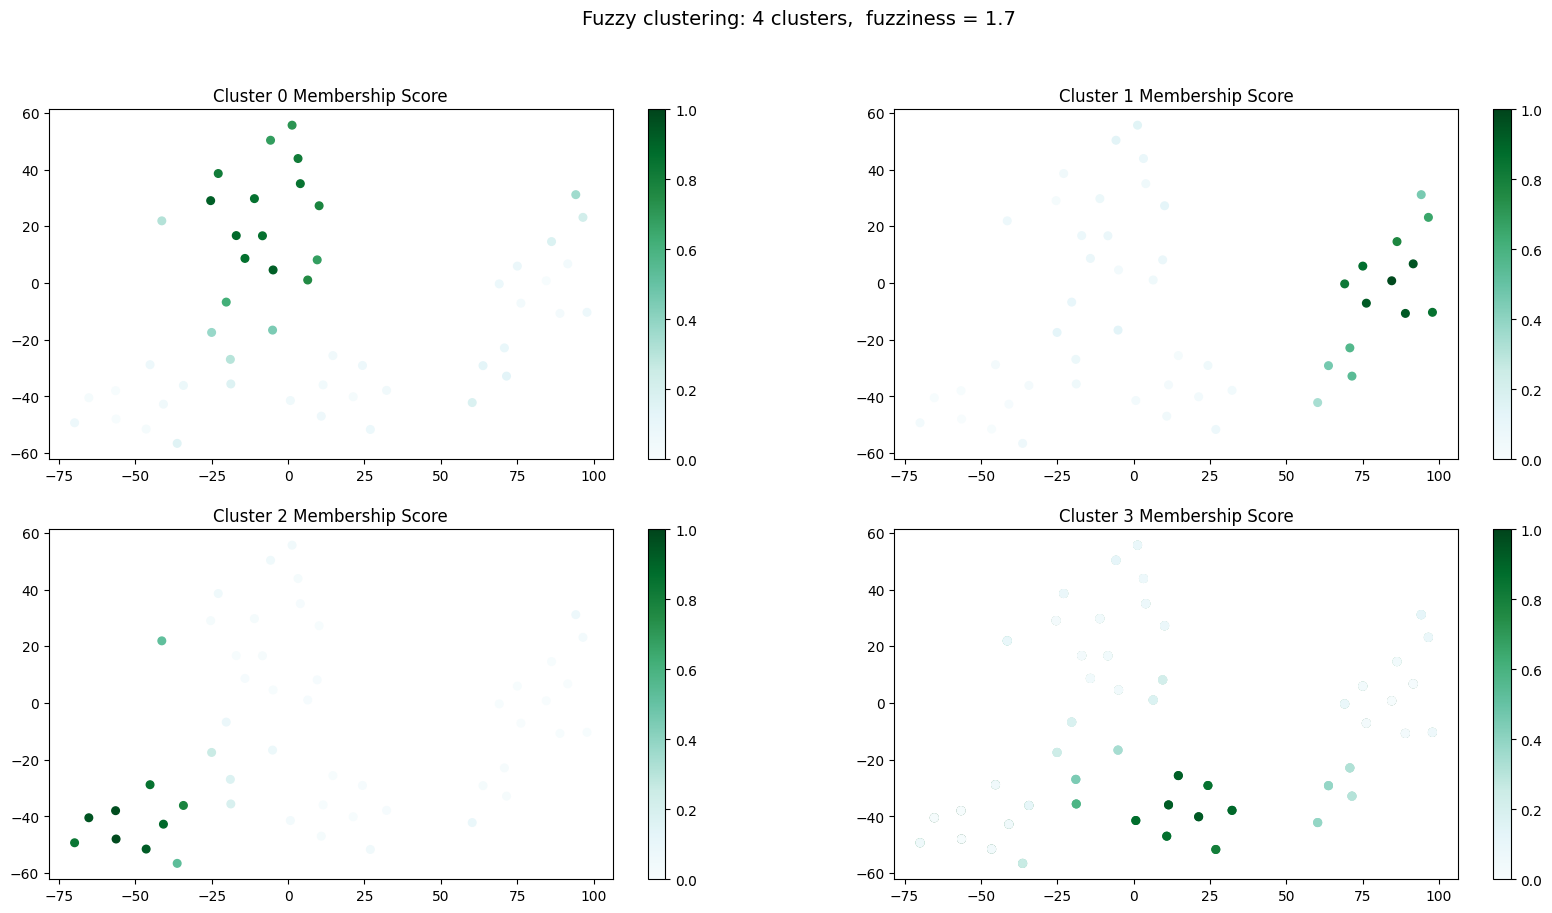

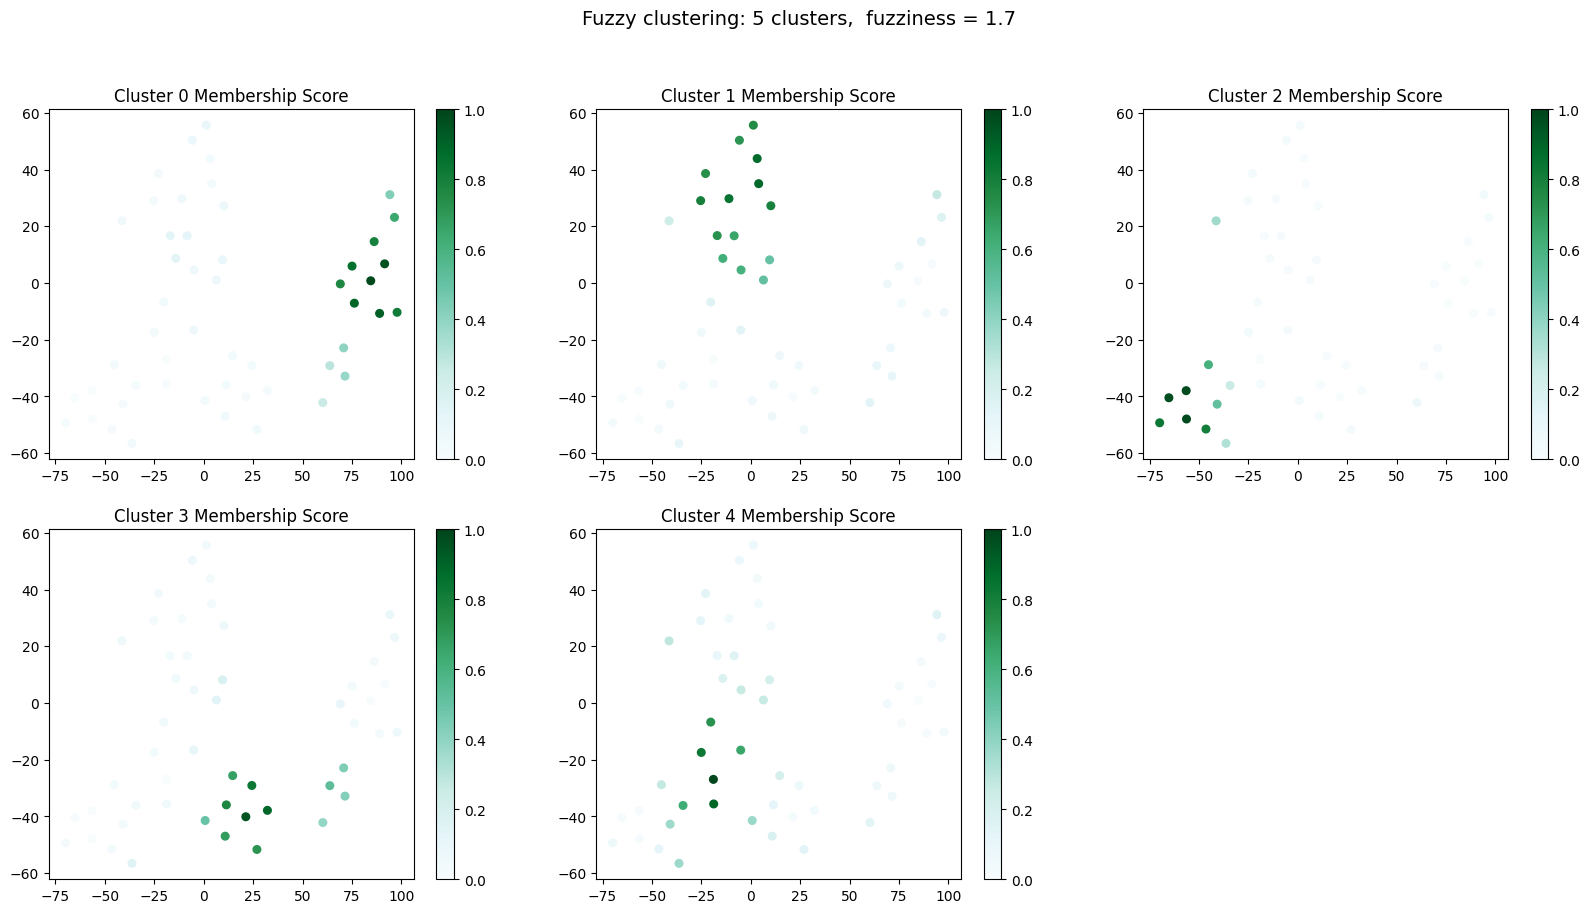

In [ ]:
# i know this is a lot of graphs
# being extra here and we can cut it down later if need


for p in [1.01, 1.1, 1.3, 1.7]:
    for c in [3, 4, 5]:

        ncols = math.ceil(math.sqrt(c))
        nrows = math.ceil(c / ncols)

        centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
        fig, ax = plt.subplots(nrows, ncols, figsize=(20,10), squeeze=False)
        plt.suptitle(f'Fuzzy clustering: {c} clusters,  fuzziness = {p}', fontsize=14)

        for i in range(0,c):

            row = i // ncols
            col = i % ncols

            df_tsne['Cluster %s Membership Score' %str(i)] = W[i,:]
            points = plt.scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
            ax[row, col].scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
            fig.colorbar(points, ax=ax[row, col])
            ax[row, col].set_title('Cluster %s Membership Score' %str(i))
        
        for j in range(c, nrows * ncols):
            row = j // ncols
            col = j % ncols
            fig.delaxes(ax[row, col])

        plt.show()

### Fuzzy c-Means Average Silhouette Score Plots

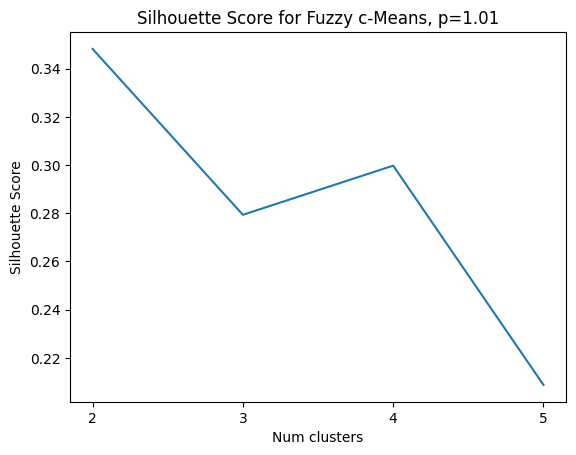

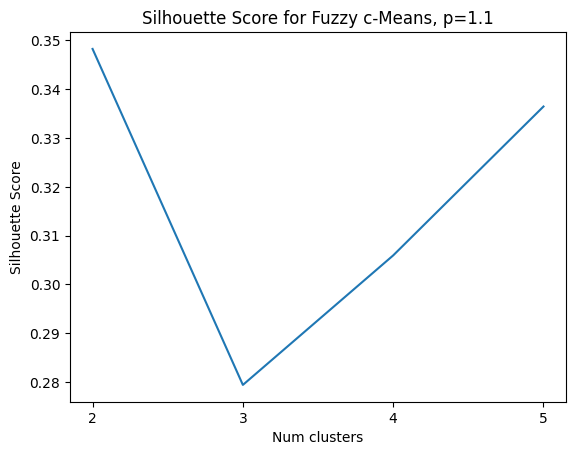

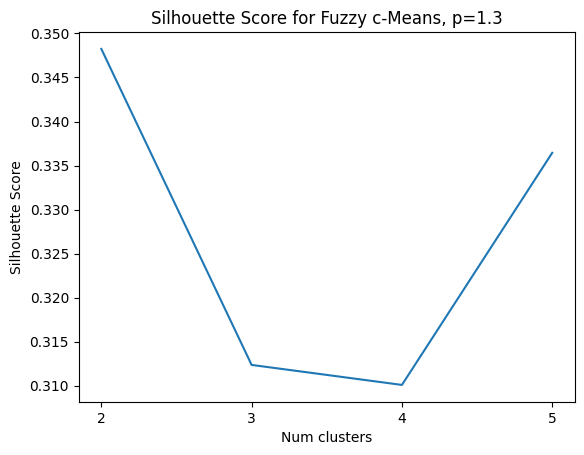

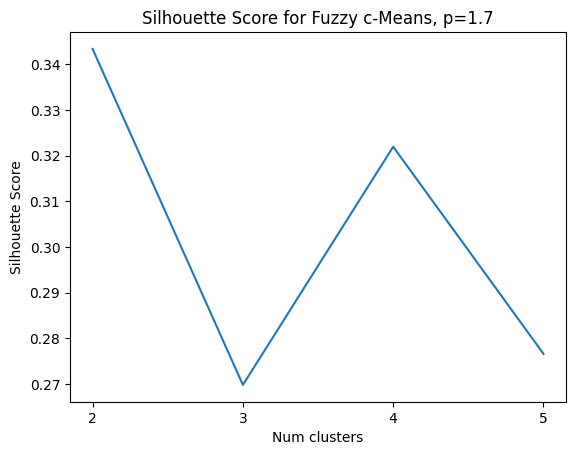

In [ ]:
for p in [1.01, 1.1, 1.3, 1.7]:
    scores = []
    for c in range(2,6):
        centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
        cluster_columns = ['Cluster %s Membership score' %(str(i)) for i in range(0,c)]
        df_membership = pd.DataFrame(W.T, columns=cluster_columns)
        partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
        scores.append(silhouette_score(X, partition_cluster_labels, metric='euclidean'))
    plt.plot(range(2, 6), scores)
    plt.xlabel("Num clusters")
    plt.xticks(range(2,6))
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score for Fuzzy c-Means, p={p}")
    plt.show()

### Fuzzy c-Means Cluster Sorted Similarity Matrix

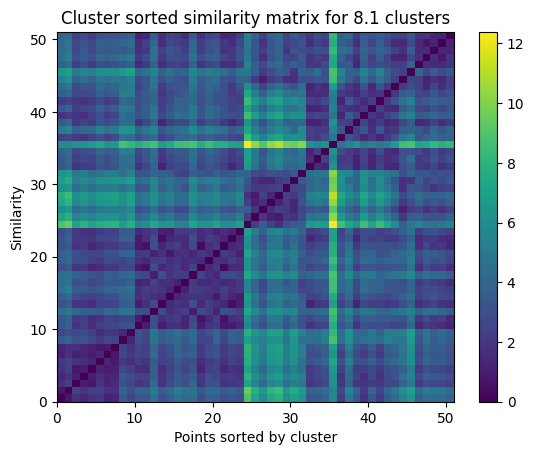

In [ ]:
# NEEDS TO BE UPDATED TO USE MANY DIFFERENT PARAM VALUES
# MANY DIFFERENT FUZZY CMEANS VARIANTS - FUZZINESS, NUM CLUSTERS, ETC

partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
df_scaled['partition_cluster_labels'] = partition_cluster_labels
df_sort = df_scaled.sort_values(by='partition_cluster_labels')
df_sort = df_sort.drop(['partition_cluster_labels'], axis=1)
dist_mat = squareform(pdist(df_sort))
plt.pcolormesh(dist_mat)
plt.colorbar()
N = len(df_sort)
plt.xlim([0,N])
plt.ylim([0,N])
plt.xlabel('Points sorted by cluster')
plt.ylabel('Similarity')
plt.title("Cluster sorted similarity matrix for howevermany clusters")
plt.show()

### Fuzzy c-Means Outlier and Noise Handling

### Fuzzy c-Means Fuzziness

### Fuzzy c-Means Best Clustering

### Fuzzy c-Means Technique Shortcomings
 #### - Elbow Plot
 #### - Average Silhouette Score
 #### - Cluster-Sorted Similarity Matrix

### Fuzzy c-Means Best Clustering Algorithm Results Presentation

## 10. Discussion

## 11. Conclusion

## References

CORGIS Datasets Project. (2021). Drugs CSV File. https://corgis-edu.github.io/corgis/csv/drugs/

Substance Abuse and Mental Health Services Administration. (2025). Know the risks of using drugs. https://www.samhsa.gov/substance-use/learn/risks